# Solve the problem leveraging ResNet-50 architecture
In this notebook, we will use the ResNet-50 architecture for our classification problem.

First, we'll try a simple **feature extraction**. Since the architecture was trained on a different dataset, we do not expect very good performance, but we can use these results as a baseline for the next step: **fine-tuning**.

## Import Libraries
First of all, let's import all the libraries we will need later.

In [1]:
from google.colab import drive
import os
import shutil
import numpy as np
import random as rn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from keras.models import Model
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.applications.xception import preprocess_input, decode_predictions

## Load dataset from Google Drive
The dataset is stored in Google Drive in a zip file, we unzip it locally for better performance.

In [2]:
drive.mount('/content/drive', force_remount=True)
!unzip -q "/content/drive/My Drive/SplittedDataset.zip" -d "/content"

Mounted at /content/drive


## Set Parameters

In [3]:
DATASET_PATH = "/content/SplittedDataset"
TRAINING_PATH = DATASET_PATH + '/training_set'
TRAINING_ALL_PATH = TRAINING_PATH + '/all'
TRAINING_HEM_PATH = TRAINING_PATH + '/hem'
VALIDATION_PATH = DATASET_PATH + '/validation_set'
TEST_PATH = DATASET_PATH + '/test_set'

LOCAL_MODELS_FOLDER = "/content/models"
if not os.path.exists(LOCAL_MODELS_FOLDER):
  os.makedirs(LOCAL_MODELS_FOLDER)
GLOBAL_MODELS_FOLDER = "/content/drive/My Drive/Baldi_Cioffo/models/resnet-101"
if not os.path.exists(GLOBAL_MODELS_FOLDER):
  os.makedirs(GLOBAL_MODELS_FOLDER)

# Default values to load the dataset
BATCH_SIZE = 32
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

## Utility Functions

In [4]:
def set_seed ():
  '''
  set_seed is used to obtain reproducible results using keras during the development phase
  '''
  seed = 24
  # The below is necessary for reproducible results of certain Python hash-based operations.
  os.environ["PYTHONHASHSEED"]="0"
  # The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
  np.random.seed(seed)
  # The below is necessary for starting core Python generated random numbers in a well-defined state.
  rn.seed(seed)
  # The below tf.random.set_seed will make random number generation in TensorFlow have a well-defined initial state.
  tf.random.set_seed(seed)

def show_training_and_validation_performance(history):
  '''
  show_training_and_validation_performance is used to plot the performances during the training phase
  :param history: object in which are recorded all the events
  '''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

def load_training_set (image_height, image_width, batch_size):
  '''
  load_training_set loads the training set from the "training_set" folder. The images are resized to height x width
  :param image_height: standard height of the images
  :param image_width: standard width of the images
  :param batch_size: size of each batch
  :return: the training set
  '''
  return image_dataset_from_directory(
    TRAINING_PATH,
    image_size = (image_height, image_width),
    batch_size = batch_size,
    class_names = ['hem', 'all']) # explicit ordering of the labels, 0 for hem, 1 for all

def load_validation_set (image_height, image_width, batch_size):
  '''
  load_validation_set loads the validation set from the "validation_set" folder. The images are resized to height x width
  :param image_height: standard height of the images
  :param image_width: standard width of the images
  :param batch_size: size of each batch
  :return: the validation set
  '''
  return image_dataset_from_directory(
    VALIDATION_PATH,
    image_size = (image_height, image_width),
    batch_size = batch_size,
    class_names = ['hem', 'all']) # explicit ordering of the labels, 0 for hem, 1 for all

def load_test_set (image_height, image_width, batch_size):
  '''
  load_test_set loads the test set from the "test_set" folder. The images are resized to height x width
  :param image_height: standard height of the images
  :param image_width: standard width of the images
  :param batch_size: size of each batch
  :return: the test set
  '''
  return image_dataset_from_directory(
    TEST_PATH,
    image_size = (image_height, image_width),
    batch_size = batch_size,
    shuffle = False,
    class_names = ['hem', 'all']) # explicit ordering of the labels, 0 for hem, 1 for all

def compile_model (model, optimizer='adam', learning_rate = 0.001):
  '''
  compile_model is used to compile the current model
  :param model: model to compile
  :param optimizer: optimizer to be used
  :param learning_rate: learning rate parameter for the optimizer
  '''
  if optimizer == 'adam':
    model.compile(loss="binary_crossentropy",
      optimizer=optimizers.Adam(learning_rate=learning_rate),
      metrics=["accuracy"])
  elif optimizer == 'rmsprop':
    model.compile(loss="binary_crossentropy",
                  optimizer = optimizers.RMSprop(learning_rate=learning_rate),
                  metrics=['accuracy'])
  model.summary()

def run_model (model, model_name, epochs = 20, patience=5, monitor='val_loss'):
  '''
  run_model is used to run the current mode
  :param model: model to run
  :param model_name: name given to save the model
  :param epochs: how many epochs to do
  :param patience: patience value for Early Stopping
  :param monitor: what to monitor for Early Stopping and Model Checkpoint
  '''
  # local save path for the models
  save_path = LOCAL_MODELS_FOLDER + '/' + model_name + '.h5'
  callbacks_list = [
                  keras.callbacks.EarlyStopping(monitor=monitor, patience=patience),
                  keras.callbacks.ModelCheckpoint(
                      filepath = save_path,
                      monitor=monitor,
                      verbose=1,
                      save_best_only=True)
                  ]
  history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset,
                    callbacks=callbacks_list)
  # save on Drive only the best model
  shutil.copy(save_path, GLOBAL_MODELS_FOLDER + '/' + model_name + '.h5')
  show_training_and_validation_performance(history)

def evaluate_model (model):
  '''
  evaluate_model is used to plot some statistics about the performance on the test set
  :param model: model to consider
  '''
  y_score = model.predict(test_dataset)
  y_pred = np.rint(y_score) # to have 0 or 1
  y_true = tf.concat([labels_batch for data_batch, labels_batch in test_dataset], axis = 0)
  print("Classification report: ")
  print(metrics.classification_report(y_true,y_pred,digits = 4))
  metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

  # ROC curve
  fpr,tpr,th = metrics.roc_curve(y_true,y_score)
  roc_auc = metrics.roc_auc_score(y_true,y_score)

  plt.figure()
  plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve')
  plt.legend(loc="lower right")
  plt.show()

## Load Dataset
The dataset, properly preprocessed, is now located in the local machine.

In [5]:
set_seed()

In [6]:
train_dataset = load_training_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)
validation_dataset = load_validation_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)
test_dataset = load_test_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)

Found 6396 files belonging to 2 classes.
Found 2132 files belonging to 2 classes.
Found 2133 files belonging to 2 classes.


## Feature extraction
Firstly, we use the pretrained network to extract feature and we define our classifiers to classify the images.

In [7]:

conv_base = tf.keras.applications.Xception(include_top = False, weights='imagenet', input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3))

83683744/83683744 [==============================] - 0s 0us/step


In [8]:
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]

In [9]:
conv_base.trainable = False

### Experiment 1: one dense layer with 64 neurons
In this first experiment we try a simple configuration with a single dense layer before the output layer.

In [10]:

inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = keras.applications.xception.preprocess_input(inputs)
x = conv_base(x) # feature extraction
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu') (x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model1 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 64)                642259

Epoch 1/30
200/200 [==============================] - ETA: 0s - loss: 0.8910 - accuracy: 0.6332
Epoch 1: val_loss improved from inf to 0.53572, saving model to /content/models/experiment1_feature_extraction.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 59s 247ms/step - loss: 0.8910 - accuracy: 0.6332 - val_loss: 0.5357 - val_accuracy: 0.7875
Epoch 2/30
200/200 [==============================] - ETA: 0s - loss: 0.5877 - accuracy: 0.7580
Epoch 2: val_loss improved from 0.53572 to 0.49333, saving model to /content/models/experiment1_feature_extraction.h5
200/200 [==============================] - 38s 186ms/step - loss: 0.5877 - accuracy: 0.7580 - val_loss: 0.4933 - val_accuracy: 0.8039
Epoch 3/30
200/200 [==============================] - ETA: 0s - loss: 0.5398 - accuracy: 0.7921
Epoch 3: val_loss improved from 0.49333 to 0.47777, saving model to /content/models/experiment1_feature_extraction.h5
200/200 [==============================] - 39s 191ms/step - loss: 0.5398 - accuracy: 0.7921 - val_loss: 0.4778 - val_accuracy: 0.8114
Epoch 4/30
200/200 [==============================] - ETA: 0s - loss: 0.4960 - accuracy: 0.8149
Epoch 4: val_loss improved from 0.47777 to 0.43371, saving model to /conte

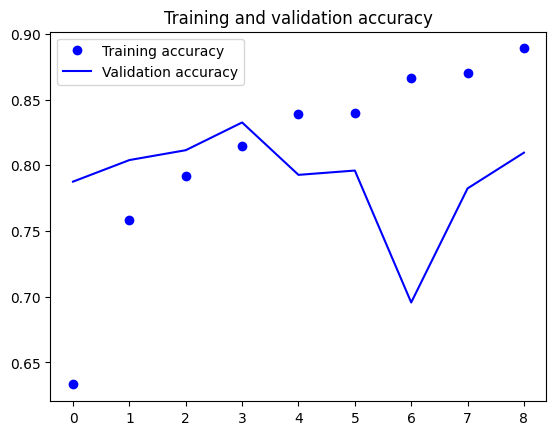

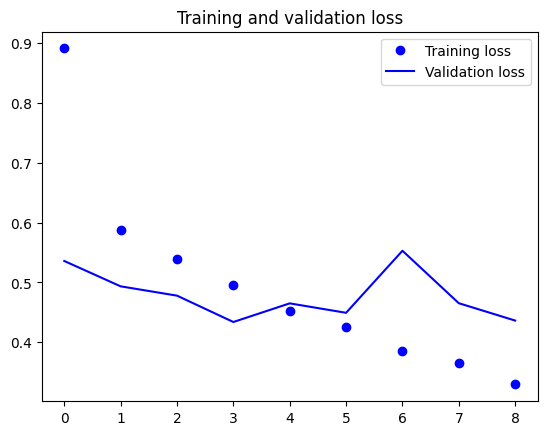

In [11]:
run_model(model1, 'experiment1_feature_extraction', epochs = 30)

67/67 [==============================] - 12s 171ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.7529    0.7399    0.7464       696
           1     0.8751    0.8824    0.8787      1437

    accuracy                         0.8359      2133
   macro avg     0.8140    0.8112    0.8126      2133
weighted avg     0.8352    0.8359    0.8355      2133



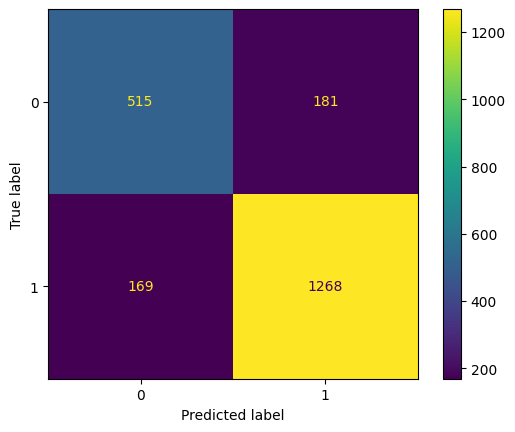

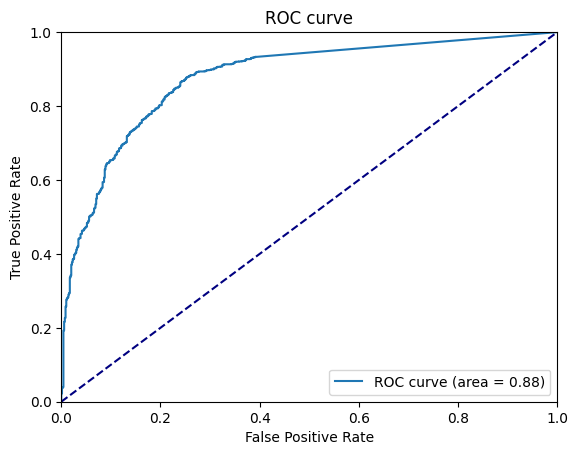

In [12]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment1_feature_extraction.h5'))

### Experiment 2: one dense layer with 32 neurons
We tried to lower the number of neurons, to fight overfitting

In [13]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = keras.applications.xception.preprocess_input(inputs)

x = conv_base(x) # feature extraction
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu') (x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model2 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model2)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 32)                3211

Epoch 1/30
200/200 [==============================] - ETA: 0s - loss: 0.7631 - accuracy: 0.7129
Epoch 1: val_loss improved from inf to 0.43026, saving model to /content/models/experiment2_feature_extraction.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 40s 182ms/step - loss: 0.7631 - accuracy: 0.7129 - val_loss: 0.4303 - val_accuracy: 0.8143
Epoch 2/30
200/200 [==============================] - ETA: 0s - loss: 0.4299 - accuracy: 0.7986
Epoch 2: val_loss did not improve from 0.43026
200/200 [==============================] - 35s 173ms/step - loss: 0.4299 - accuracy: 0.7986 - val_loss: 0.4896 - val_accuracy: 0.7810
Epoch 3/30
200/200 [==============================] - ETA: 0s - loss: 0.3766 - accuracy: 0.8307
Epoch 3: val_loss improved from 0.43026 to 0.39577, saving model to /content/models/experiment2_feature_extraction.h5
200/200 [==============================] - 36s 177ms/step - loss: 0.3766 - accuracy: 0.8307 - val_loss: 0.3958 - val_accuracy: 0.8307
Epoch 4/30
200/200 [==============================] - ETA: 0s - loss: 0.3499 - accuracy: 0.8416
Epoch 4: val_loss did not improve from 0.39577
200/200 [==============================] - 35s 174ms/step - loss: 0.3499 - accuracy: 0.8416 - val_

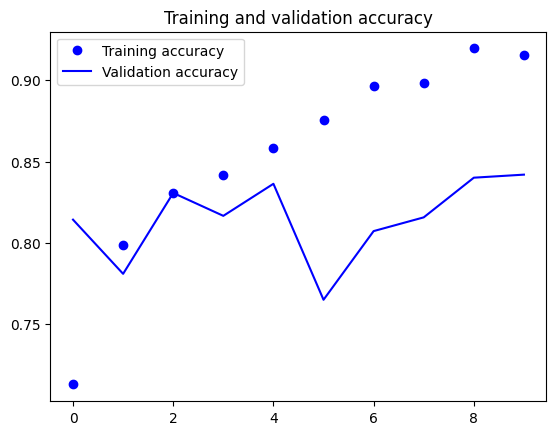

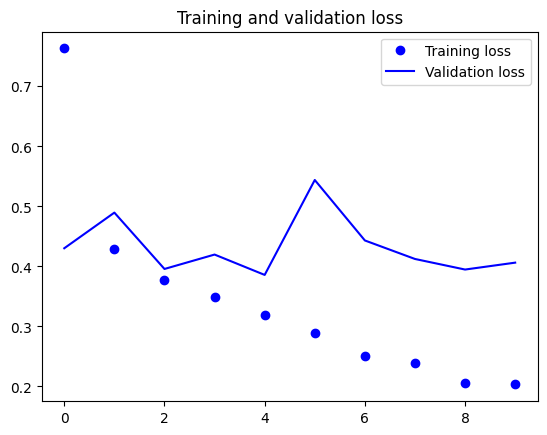

In [14]:
run_model(model2, 'experiment2_feature_extraction', epochs = 30)

67/67 [==============================] - 9s 125ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.7216    0.7859    0.7524       696
           1     0.8916    0.8532    0.8720      1437

    accuracy                         0.8312      2133
   macro avg     0.8066    0.8195    0.8122      2133
weighted avg     0.8362    0.8312    0.8330      2133



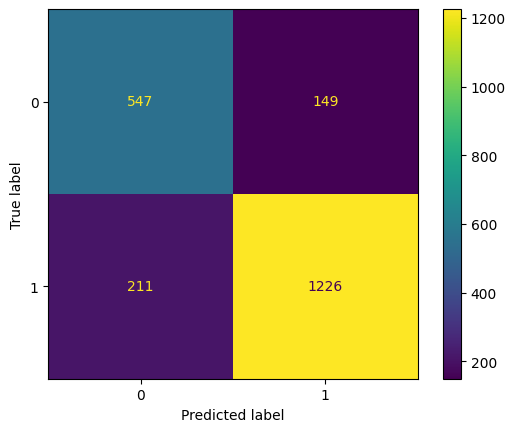

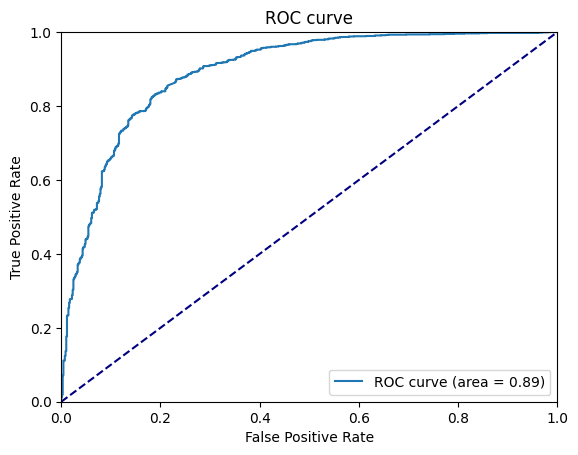

In [15]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment2_feature_extraction.h5'))

### Experiment 3: one dense layer with 64 neurons and dropout
Lowering the capacity of the networks leads us to underfitting, we could try to use Dropout instead.

In [16]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = keras.applications.xception.preprocess_input(inputs)
x = conv_base(x) # feature extraction
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu') (x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model3 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model3)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_2 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_4 (Dense)             (None, 64)                6422

Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: 1.0892 - accuracy: 0.7059
Epoch 1: val_loss improved from inf to 0.46394, saving model to /content/models/experiment3_feature_extraction.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 41s 186ms/step - loss: 1.0892 - accuracy: 0.7059 - val_loss: 0.4639 - val_accuracy: 0.7936
Epoch 2/50
200/200 [==============================] - ETA: 0s - loss: 0.4828 - accuracy: 0.7686
Epoch 2: val_loss improved from 0.46394 to 0.44074, saving model to /content/models/experiment3_feature_extraction.h5
200/200 [==============================] - 37s 186ms/step - loss: 0.4828 - accuracy: 0.7686 - val_loss: 0.4407 - val_accuracy: 0.8250
Epoch 3/50
200/200 [==============================] - ETA: 0s - loss: 0.4445 - accuracy: 0.7739
Epoch 3: val_loss did not improve from 0.44074
200/200 [==============================] - 37s 183ms/step - loss: 0.4445 - accuracy: 0.7739 - val_loss: 0.4584 - val_accuracy: 0.7735
Epoch 4/50
200/200 [==============================] - ETA: 0s - loss: 0.4286 - accuracy: 0.7813
Epoch 4: val_loss improved from 0.44074 to 0.43914, saving model to /content/models/experiment3_feature_extraction.h5
200/200 [==================

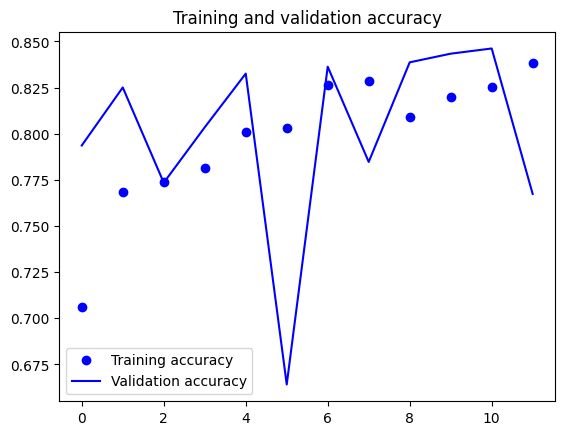

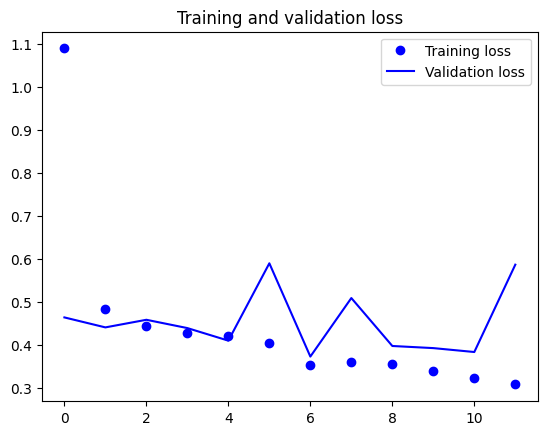

In [17]:
run_model(model3, 'experiment3_feature_extraction', epochs = 50)

67/67 [==============================] - 13s 162ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.8709    0.5718    0.6904       696
           1     0.8222    0.9589    0.8853      1437

    accuracy                         0.8326      2133
   macro avg     0.8465    0.7654    0.7878      2133
weighted avg     0.8381    0.8326    0.8217      2133



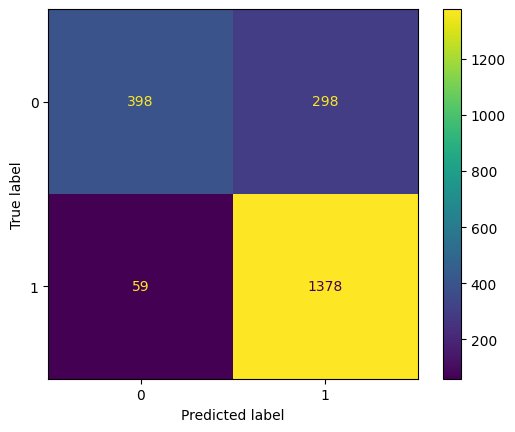

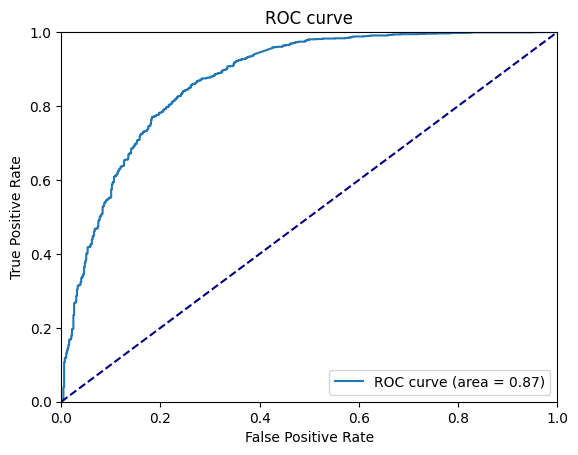

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment3_feature_extraction.h5'))

### Experiment 4: global average pooling
Try GlobalAveragePooling instead of fully connected layers, to lower the number of parameters.

In [18]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = keras.applications.xception.preprocess_input(inputs)
x = conv_base(x) # feature extraction
x = layers.GlobalAveragePooling2D() (x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model4 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model4)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_3 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_3 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                           

Epoch 1/20
200/200 [==============================] - ETA: 0s - loss: 0.5702 - accuracy: 0.7112
Epoch 1: val_loss improved from inf to 0.53908, saving model to /content/models/experiment4_feature_extraction.h5
200/200 [==============================] - 38s 178ms/step - loss: 0.5702 - accuracy: 0.7112 - val_loss: 0.5391 - val_accuracy: 0.7237
Epoch 2/20
200/200 [==============================] - ETA: 0s - loss: 0.5137 - accuracy: 0.7536
Epoch 2: val_loss improved from 0.53908 to 0.50848, saving model to /content/models/experiment4_feature_extraction.h5
200/200 [==============================] - 35s 175ms/step - loss: 0.5137 - accuracy: 0.7536 - val_loss: 0.5085 - val_accuracy: 0.7500
Epoch 3/20
200/200 [==============================] - ETA: 0s - loss: 0.4920 - accuracy: 0.7656
Epoch 3: val_loss improved from 0.50848 to 0.45842, saving model to /content/models/experiment4_feature_extraction.h5
200/200 [==============================] - 37s 183ms/step - loss: 0.4920 - accuracy: 0.7656 - 

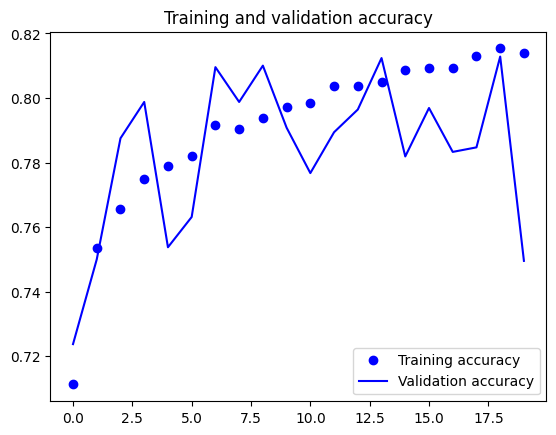

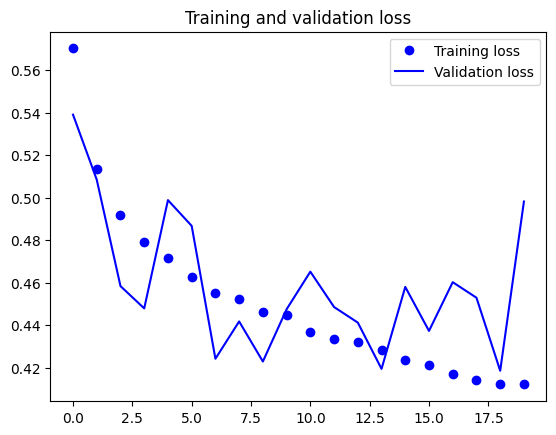

In [19]:
run_model(model4, "experiment4_feature_extraction", epochs=20)

67/67 [==============================] - 10s 130ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.6792    0.7759    0.7243       696
           1     0.8834    0.8225    0.8519      1437

    accuracy                         0.8073      2133
   macro avg     0.7813    0.7992    0.7881      2133
weighted avg     0.8168    0.8073    0.8103      2133



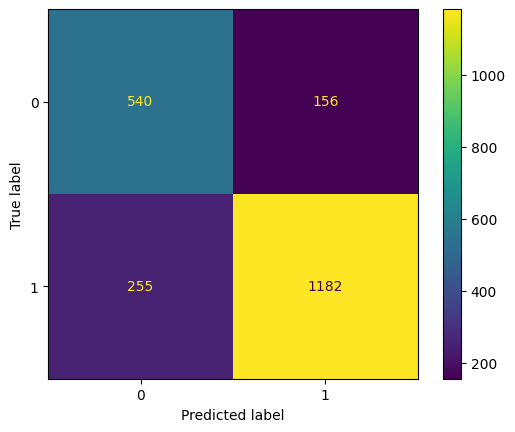

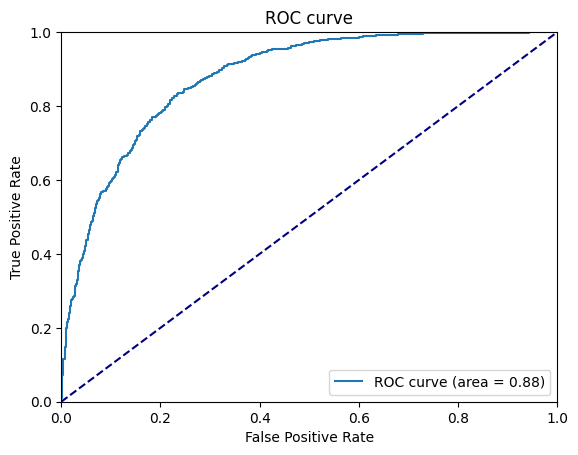

In [20]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment4_feature_extraction.h5'))

### Experiment 5: global average pooling and two dense layers

In [21]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = keras.applications.xception.preprocess_input(inputs)
x = conv_base(x) # feature extraction
x = layers.GlobalAveragePooling2D() (x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model5 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model5, optimizer='rmsprop')

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_4 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_4 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                           

Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: 0.5970 - accuracy: 0.6939
Epoch 1: val_loss improved from inf to 0.75487, saving model to /content/models/Experiment5_feature_extraction.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 40s 181ms/step - loss: 0.5970 - accuracy: 0.6939 - val_loss: 0.7549 - val_accuracy: 0.6468
Epoch 2/50
200/200 [==============================] - ETA: 0s - loss: 0.5081 - accuracy: 0.7500
Epoch 2: val_loss improved from 0.75487 to 0.45922, saving model to /content/models/Experiment5_feature_extraction.h5
200/200 [==============================] - 35s 175ms/step - loss: 0.5081 - accuracy: 0.7500 - val_loss: 0.4592 - val_accuracy: 0.8138
Epoch 3/50
200/200 [==============================] - ETA: 0s - loss: 0.4862 - accuracy: 0.7630
Epoch 3: val_loss improved from 0.45922 to 0.41225, saving model to /content/models/Experiment5_feature_extraction.h5
200/200 [==============================] - 36s 177ms/step - loss: 0.4862 - accuracy: 0.7630 - val_loss: 0.4122 - val_accuracy: 0.8255
Epoch 4/50
200/200 [==============================] - ETA: 0s - loss: 0.4641 - accuracy: 0.7781
Epoch 4: val_loss improved from 0.41225 to 0.41128, saving model to /conte

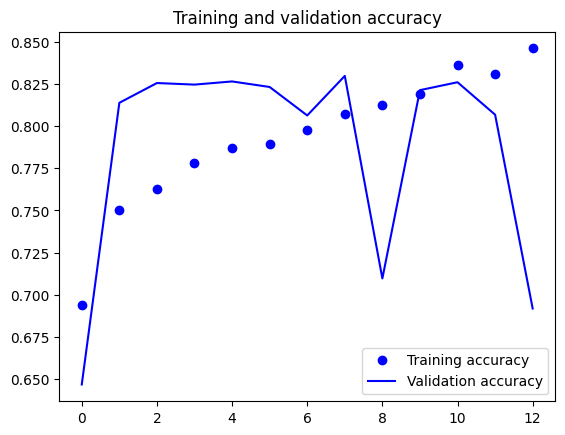

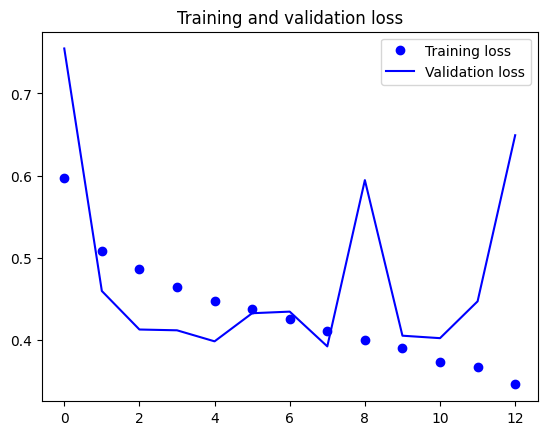

In [22]:
run_model(model5, 'Experiment5_feature_extraction', epochs=50)

67/67 [==============================] - 9s 126ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.7198    0.7270    0.7234       696
           1     0.8671    0.8629    0.8650      1437

    accuracy                         0.8186      2133
   macro avg     0.7935    0.7950    0.7942      2133
weighted avg     0.8190    0.8186    0.8188      2133



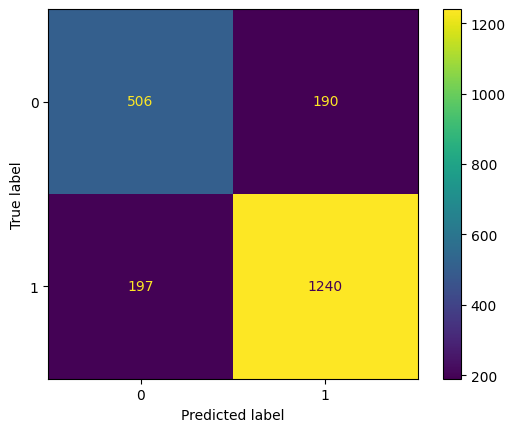

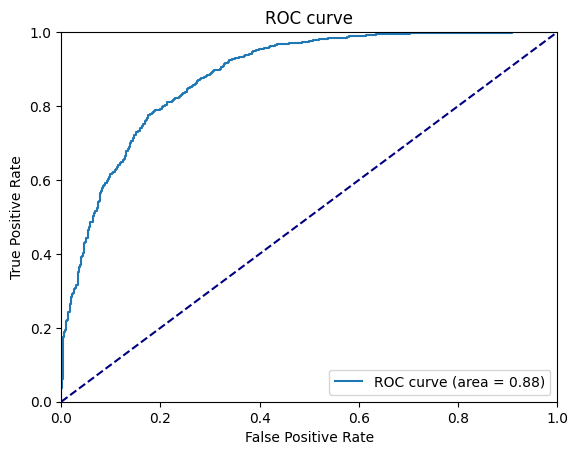

In [23]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment5_feature_extraction.h5'))

## Fine-tuning

### Experiment 1: one dense layer

In [25]:
model1 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment1_feature_extraction.h5')

set_trainable = False
for layer in model1.get_layer('xception').layers:
    if layer.name == 'conv5_block3_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(model1, learning_rate=1e-5)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 64)                642259

Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: 0.4510 - accuracy: 0.8437
Epoch 1: val_loss improved from inf to 0.44396, saving model to /content/models/experiment1_fine_tuning.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 42s 190ms/step - loss: 0.4510 - accuracy: 0.8437 - val_loss: 0.4440 - val_accuracy: 0.8255
Epoch 2/50
200/200 [==============================] - ETA: 0s - loss: 0.4491 - accuracy: 0.8491
Epoch 2: val_loss improved from 0.44396 to 0.44284, saving model to /content/models/experiment1_fine_tuning.h5
200/200 [==============================] - 38s 190ms/step - loss: 0.4491 - accuracy: 0.8491 - val_loss: 0.4428 - val_accuracy: 0.8265
Epoch 3/50
200/200 [==============================] - ETA: 0s - loss: 0.4480 - accuracy: 0.8487
Epoch 3: val_loss did not improve from 0.44284
200/200 [==============================] - 37s 186ms/step - loss: 0.4480 - accuracy: 0.8487 - val_loss: 0.4430 - val_accuracy: 0.8250
Epoch 4/50
200/200 [==============================] - ETA: 0s - loss: 0.4470 - accuracy: 0.8504
Epoch 4: val_loss improved from 0.44284 to 0.44143, saving model to /content/models/experiment1_fine_tuning.h5
200/200 [==============================] 

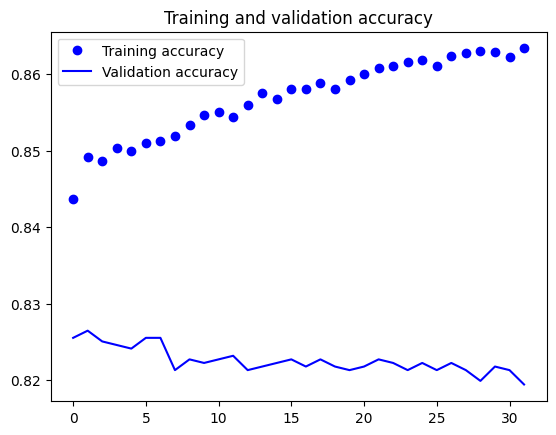

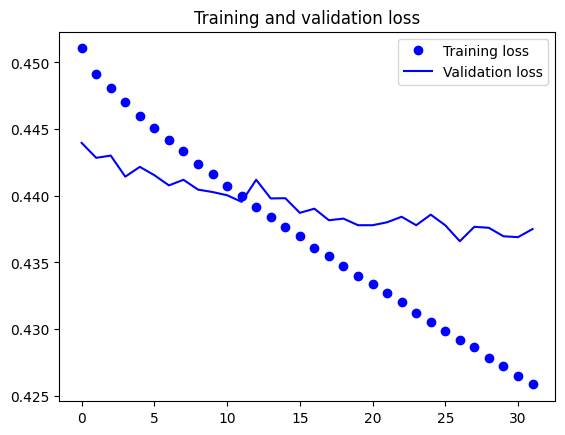

In [26]:
run_model(model1, "experiment1_fine_tuning", epochs=50)

67/67 [==============================] - 9s 128ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.7031    0.7859    0.7422       696
           1     0.8900    0.8392    0.8639      1437

    accuracy                         0.8218      2133
   macro avg     0.7966    0.8126    0.8030      2133
weighted avg     0.8290    0.8218    0.8242      2133



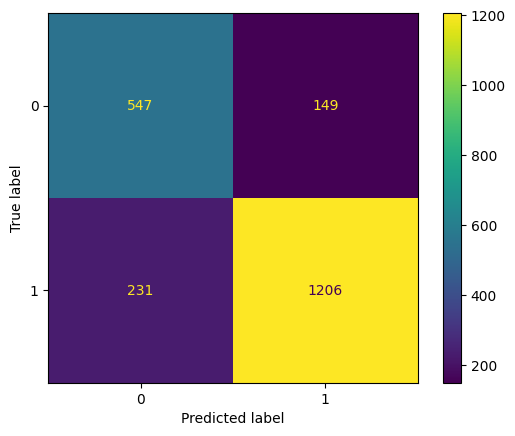

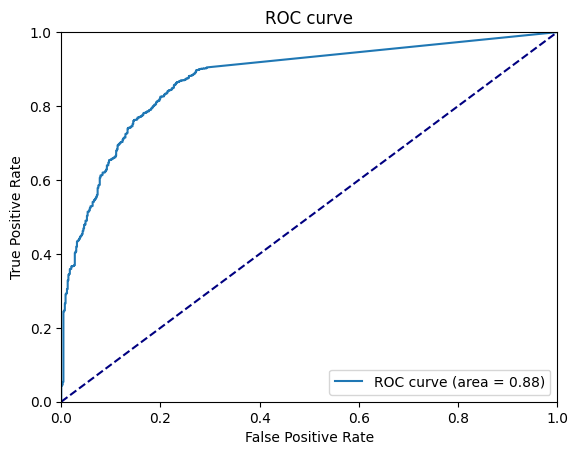

In [27]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment1_fine_tuning.h5'))

### Experiment 2: global average pooling

In [28]:
model4 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment4_feature_extraction.h5')

set_trainable = False
# fine-tune the last three elements
for layer in model4.get_layer('xception').layers:
    if layer.name == 'conv5_block3_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(model4, learning_rate=1e-5)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_3 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_3 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                           

Epoch 1/20
200/200 [==============================] - ETA: 0s - loss: 0.4051 - accuracy: 0.8233
Epoch 1: val_loss improved from inf to 0.42576, saving model to /content/models/Experiment2_fine_tuning.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 40s 186ms/step - loss: 0.4051 - accuracy: 0.8233 - val_loss: 0.4258 - val_accuracy: 0.8082
Epoch 2/20
200/200 [==============================] - ETA: 0s - loss: 0.4048 - accuracy: 0.8236
Epoch 2: val_loss did not improve from 0.42576
200/200 [==============================] - 35s 173ms/step - loss: 0.4048 - accuracy: 0.8236 - val_loss: 0.4280 - val_accuracy: 0.8082
Epoch 3/20
200/200 [==============================] - ETA: 0s - loss: 0.4048 - accuracy: 0.8238
Epoch 3: val_loss did not improve from 0.42576
200/200 [==============================] - 35s 174ms/step - loss: 0.4048 - accuracy: 0.8238 - val_loss: 0.4287 - val_accuracy: 0.8086
Epoch 4/20
200/200 [==============================] - ETA: 0s - loss: 0.4047 - accuracy: 0.8238
Epoch 4: val_loss did not improve from 0.42576
200/200 [==============================] - 36s 181ms/step - loss: 0.4047 - accuracy: 0.8238 - val_loss: 0.4285 - val_accuracy: 0.8086
Epoch 5/20
200/200 [===============

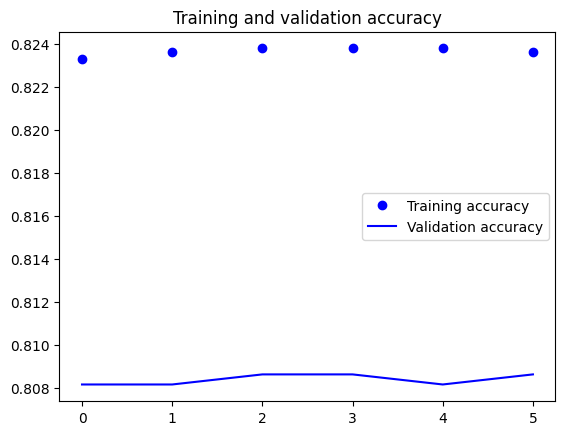

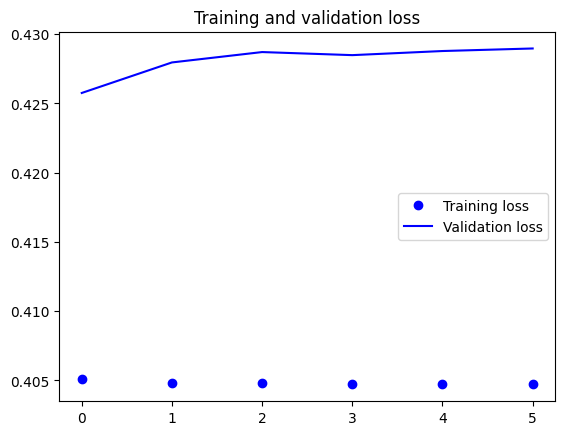

In [29]:
run_model(model4, "Experiment2_fine_tuning")

67/67 [==============================] - 9s 125ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.6602    0.7845    0.7170       696
           1     0.8851    0.8045    0.8429      1437

    accuracy                         0.7979      2133
   macro avg     0.7727    0.7945    0.7799      2133
weighted avg     0.8118    0.7979    0.8018      2133



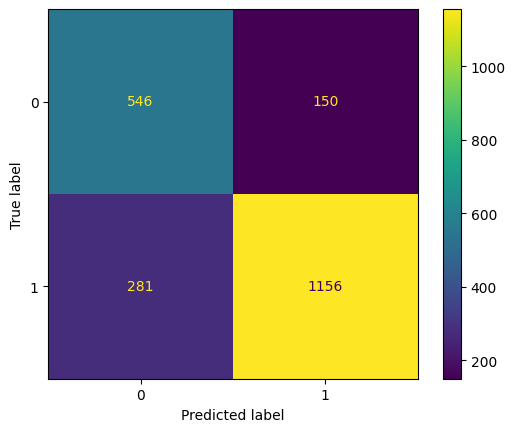

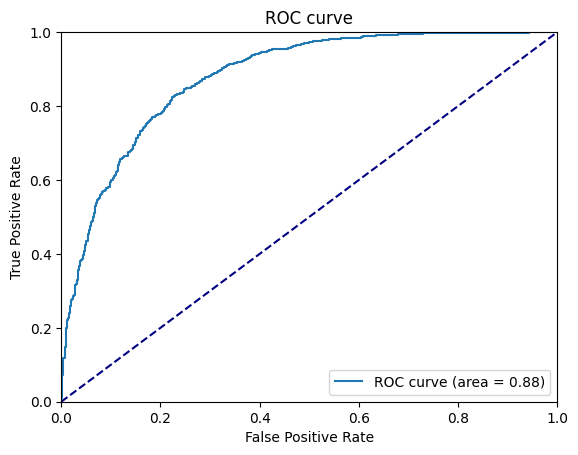

In [30]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment2_fine_tuning.h5'))

### Experiment 3: global average pooling and two dense layers

In [31]:
model5 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment5_feature_extraction.h5')

set_trainable = False
for layer in model5.get_layer('xception').layers:
    if layer.name == 'conv5_block3_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(model5, optimizer='rmsprop', learning_rate=1e-5)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_4 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_4 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                           

Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: 0.3561 - accuracy: 0.8347
Epoch 1: val_loss improved from inf to 0.40588, saving model to /content/models/Experiment3_fine_tuning.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 40s 183ms/step - loss: 0.3561 - accuracy: 0.8347 - val_loss: 0.4059 - val_accuracy: 0.8218
Epoch 2/50
200/200 [==============================] - ETA: 0s - loss: 0.3502 - accuracy: 0.8382
Epoch 2: val_loss did not improve from 0.40588
200/200 [==============================] - 37s 182ms/step - loss: 0.3502 - accuracy: 0.8382 - val_loss: 0.4061 - val_accuracy: 0.8208
Epoch 3/50
200/200 [==============================] - ETA: 0s - loss: 0.3466 - accuracy: 0.8394
Epoch 3: val_loss did not improve from 0.40588
200/200 [==============================] - 35s 176ms/step - loss: 0.3466 - accuracy: 0.8394 - val_loss: 0.4072 - val_accuracy: 0.8194
Epoch 4/50
200/200 [==============================] - ETA: 0s - loss: 0.3439 - accuracy: 0.8405
Epoch 4: val_loss improved from 0.40588 to 0.40573, saving model to /content/models/Experiment3_fine_tuning.h5
200/200 [==============================] - 36s 177ms/step - loss: 0.3439 - accuracy: 0.8405 - val_loss: 0

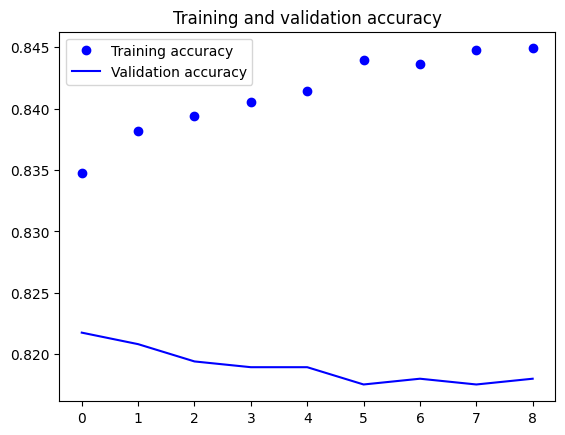

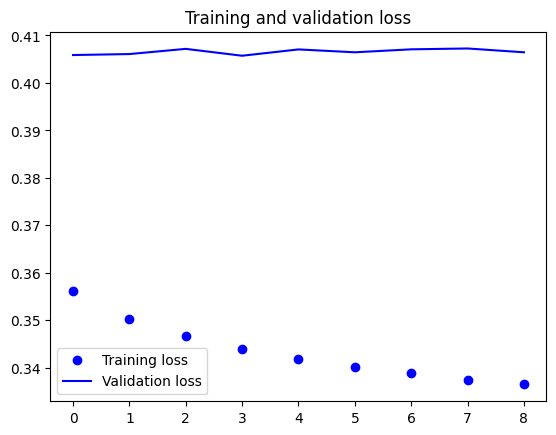

In [32]:
run_model(model5, "Experiment3_fine_tuning", epochs=50)

67/67 [==============================] - 9s 130ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.6725    0.7730    0.7193       696
           1     0.8815    0.8177    0.8484      1437

    accuracy                         0.8031      2133
   macro avg     0.7770    0.7953    0.7838      2133
weighted avg     0.8133    0.8031    0.8062      2133



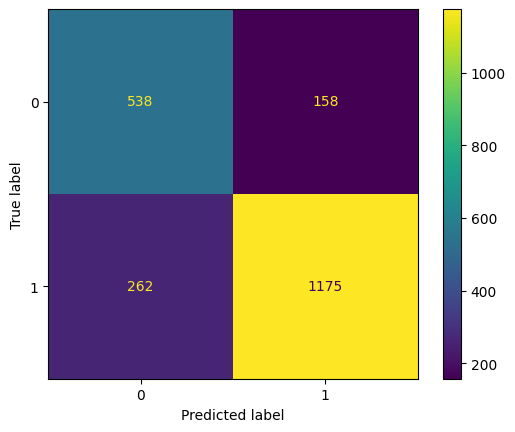

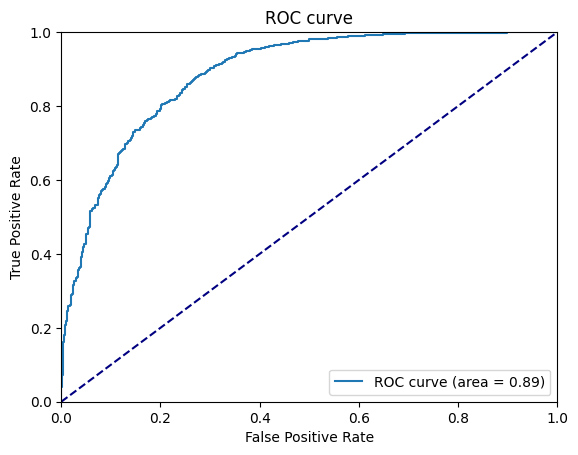

In [33]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment3_fine_tuning.h5'))

## Remove final block (5-th block)
Due to Colab's limitations we only took part of the original dataset, so now our dataset is small and very different from the one the pre-trained network was trained on. In this case it may be good to try to remove some of the final layers of the pre-trained network whose filters deal with finding detailed features. We will use less specific features that we find in previous levels.

In [49]:
def get_index_by_layer_name(model, layer_name):
  '''
  get_index_by_layer_name is used to retrieve the index of a specific layer
  :param model: model to check
  :param layer_name: name of the layer we want to get the index of
  :return: the index of the layer named as defined in layer_name
  '''
  for index, layer in enumerate(model.layers):
      print(layer.name)
      if layer.name == layer_name:
          print(layer_name)
          return index

In [50]:
conv_base = keras.applications.Xception(include_top = False, weights='imagenet', input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3))

Remove the last convolutionary block of ResNet50.

In [52]:

base = Model(conv_base.input, conv_base.layers[get_index_by_layer_name(conv_base, 'conv2d_15')].output, name='base')
base.trainable = False
base.summary()

input_11
block1_conv1
block1_conv1_bn
block1_conv1_act
block1_conv2
block1_conv2_bn
block1_conv2_act
block2_sepconv1
block2_sepconv1_bn
block2_sepconv2_act
block2_sepconv2
block2_sepconv2_bn
conv2d_12
block2_pool
batch_normalization_12
add_36
block3_sepconv1_act
block3_sepconv1
block3_sepconv1_bn
block3_sepconv2_act
block3_sepconv2
block3_sepconv2_bn
conv2d_13
block3_pool
batch_normalization_13
add_37
block4_sepconv1_act
block4_sepconv1
block4_sepconv1_bn
block4_sepconv2_act
block4_sepconv2
block4_sepconv2_bn
conv2d_14
block4_pool
batch_normalization_14
add_38
block5_sepconv1_act
block5_sepconv1
block5_sepconv1_bn
block5_sepconv2_act
block5_sepconv2
block5_sepconv2_bn
block5_sepconv3_act
block5_sepconv3
block5_sepconv3_bn
add_39
block6_sepconv1_act
block6_sepconv1
block6_sepconv1_bn
block6_sepconv2_act
block6_sepconv2
block6_sepconv2_bn
block6_sepconv3_act
block6_sepconv3
block6_sepconv3_bn
add_40
block7_sepconv1_act
block7_sepconv1
block7_sepconv1_bn
block7_sepconv2_act
block7_sepconv

### Feature extraction
Firstly, we will try to use the new base network to extract the features; we will put a classifier on top of the base network. We couldn't afford to use the Flatten, the output of the base network is 14x14x1024, too much. So we decided to use the GlobalAveragePooling2D.

#### Experiment 1: one dense layer with 256 neurons
In this first example we use just a Dense layer before the output layer.

In [54]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = keras.applications.xception.preprocess_input(inputs)
x = base(x)
x = layers.GlobalAveragePooling2D() (x)
x = layers.Dense(256)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model1 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model1)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_5 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_5 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 base (Functional)           (None, 7, 7, 1024)        14805848  
                                                                 
 global_average_pooling2d_2  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                           

Epoch 1/30
200/200 [==============================] - ETA: 0s - loss: 1.5831 - accuracy: 0.6870
Epoch 1: val_loss improved from inf to 1.14516, saving model to /content/models/Experiment1_remove_blocks_feature_extraction.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 37s 172ms/step - loss: 1.5831 - accuracy: 0.6870 - val_loss: 1.1452 - val_accuracy: 0.5023
Epoch 2/30
200/200 [==============================] - ETA: 0s - loss: 0.7666 - accuracy: 0.7194
Epoch 2: val_loss improved from 1.14516 to 0.42478, saving model to /content/models/Experiment1_remove_blocks_feature_extraction.h5
200/200 [==============================] - 31s 156ms/step - loss: 0.7666 - accuracy: 0.7194 - val_loss: 0.4248 - val_accuracy: 0.8241
Epoch 3/30
200/200 [==============================] - ETA: 0s - loss: 0.5728 - accuracy: 0.7491
Epoch 3: val_loss improved from 0.42478 to 0.40234, saving model to /content/models/Experiment1_remove_blocks_feature_extraction.h5
200/200 [==============================] - 33s 162ms/step - loss: 0.5728 - accuracy: 0.7491 - val_loss: 0.4023 - val_accuracy: 0.8316
Epoch 4/30
200/200 [==============================] - ETA: 0s - loss: 0.6348 - accuracy: 0.7337
Epoch 4: val_loss did not improve from 0.40234

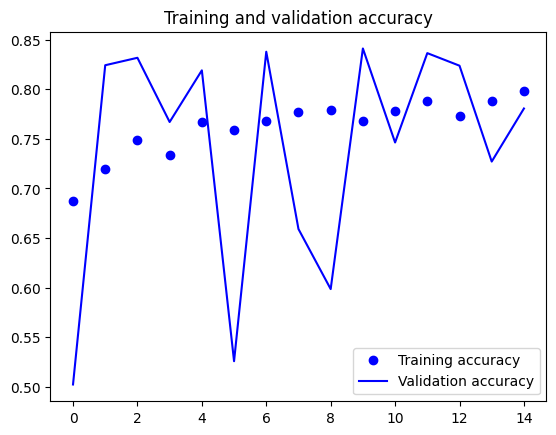

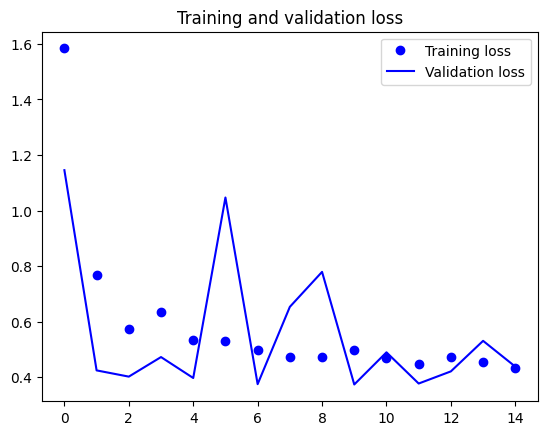

In [55]:
run_model(model1, "Experiment1_remove_blocks_feature_extraction", epochs=30)

67/67 [==============================] - 9s 119ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.7848    0.6810    0.7292       696
           1     0.8548    0.9095    0.8813      1437

    accuracy                         0.8350      2133
   macro avg     0.8198    0.7953    0.8053      2133
weighted avg     0.8320    0.8350    0.8317      2133



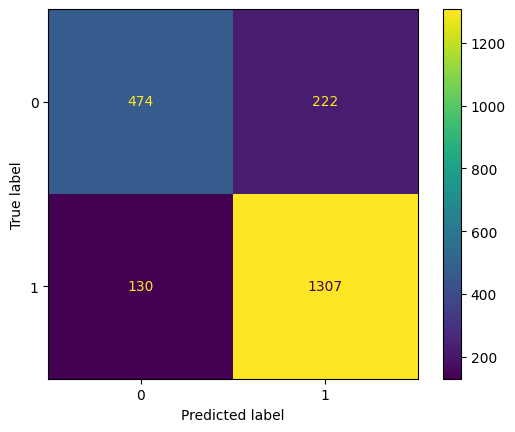

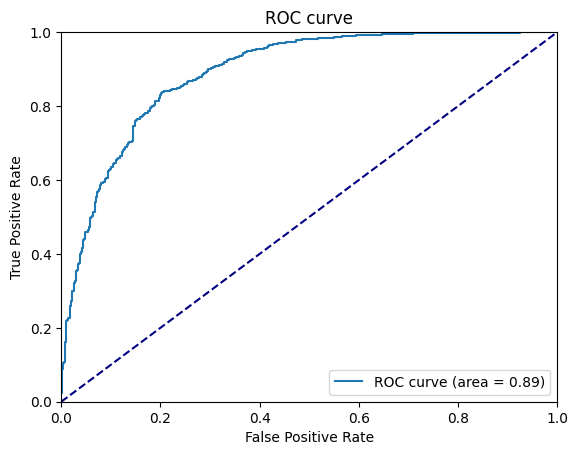

In [56]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment1_remove_blocks_feature_extraction.h5'))

#### Experiment 2: one dense layer with 256 neurons and dropout
Try to use Dropout.

In [57]:
# define the classifier
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = keras.applications.resnet_v2.preprocess_input(inputs)
x = base(x)
x = layers.GlobalAveragePooling2D() (x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model2 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model2)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_6 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_6 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 base (Functional)           (None, 7, 7, 1024)        14805848  
                                                                 
 global_average_pooling2d_3  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                           

Epoch 1/20
200/200 [==============================] - ETA: 0s - loss: 2.0773 - accuracy: 0.6477
Epoch 1: val_loss improved from inf to 0.58206, saving model to /content/models/Experiment2_remove_blocks_feature_extraction.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 38s 176ms/step - loss: 2.0773 - accuracy: 0.6477 - val_loss: 0.5821 - val_accuracy: 0.7641
Epoch 2/20
200/200 [==============================] - ETA: 0s - loss: 1.1252 - accuracy: 0.6884
Epoch 2: val_loss did not improve from 0.58206
200/200 [==============================] - 32s 160ms/step - loss: 1.1252 - accuracy: 0.6884 - val_loss: 0.6860 - val_accuracy: 0.8133
Epoch 3/20
200/200 [==============================] - ETA: 0s - loss: 0.7763 - accuracy: 0.7245
Epoch 3: val_loss improved from 0.58206 to 0.40486, saving model to /content/models/Experiment2_remove_blocks_feature_extraction.h5
200/200 [==============================] - 32s 161ms/step - loss: 0.7763 - accuracy: 0.7245 - val_loss: 0.4049 - val_accuracy: 0.8401
Epoch 4/20
200/200 [==============================] - ETA: 0s - loss: 0.5868 - accuracy: 0.7459
Epoch 4: val_loss improved from 0.40486 to 0.38385, saving model to /content/models/Experiment2_remove_blocks_feature_extraction.h5

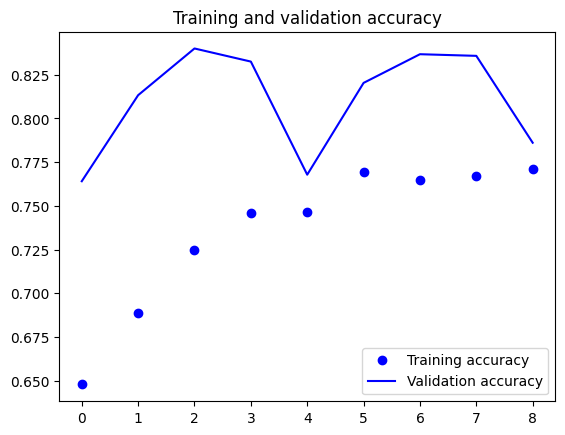

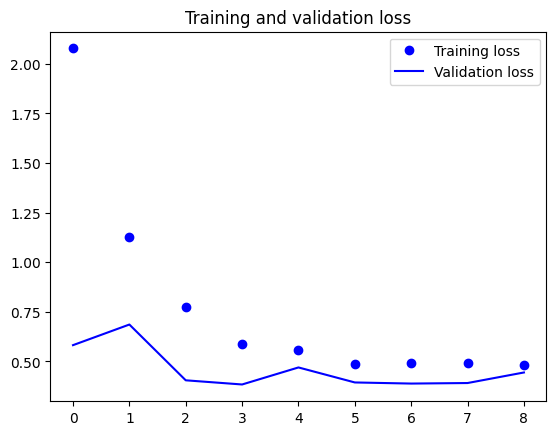

In [58]:
run_model(model2, "Experiment2_remove_blocks_feature_extraction")

67/67 [==============================] - 8s 116ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.7404    0.7213    0.7307       696
           1     0.8667    0.8775    0.8721      1437

    accuracy                         0.8265      2133
   macro avg     0.8035    0.7994    0.8014      2133
weighted avg     0.8255    0.8265    0.8259      2133



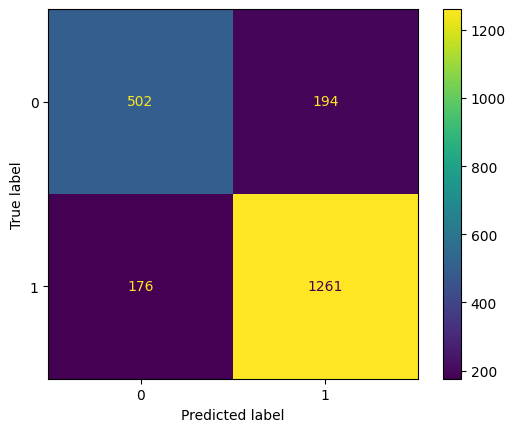

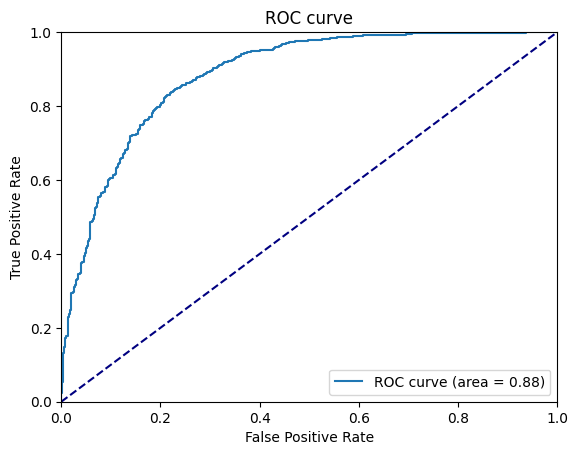

In [59]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment2_remove_blocks_feature_extraction.h5'))

#### Experiment 3: two dense layers, 256-128 neurons
Try to make a more complex network, increasing the dense layers.

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = keras.applications.resnet_v2.preprocess_input(inputs)
x = base(x)
x = layers.GlobalAveragePooling2D() (x)
x = layers.Dense(256)(x)
x = layers.Dense(128)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model3 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model3)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_9 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_9 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 base (Functional)           (None, 14, 14, 1024)      8573440   
                                                                 
 global_average_pooling2d_4  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                           

Epoch 1/20
200/200 [==============================] - ETA: 0s - loss: 0.6042 - accuracy: 0.6992
Epoch 1: val_loss improved from inf to 0.61245, saving model to /content/models/Experiment3_remove_blocks_feature_extraction.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 27s 117ms/step - loss: 0.6042 - accuracy: 0.6992 - val_loss: 0.6124 - val_accuracy: 0.6360
Epoch 2/20
200/200 [==============================] - ETA: 0s - loss: 0.4906 - accuracy: 0.7728
Epoch 2: val_loss did not improve from 0.61245
200/200 [==============================] - 22s 109ms/step - loss: 0.4906 - accuracy: 0.7728 - val_loss: 0.9706 - val_accuracy: 0.4231
Epoch 3/20
200/200 [==============================] - ETA: 0s - loss: 0.5024 - accuracy: 0.7534
Epoch 3: val_loss improved from 0.61245 to 0.49581, saving model to /content/models/Experiment3_remove_blocks_feature_extraction.h5
200/200 [==============================] - 27s 134ms/step - loss: 0.5024 - accuracy: 0.7534 - val_loss: 0.4958 - val_accuracy: 0.7439
Epoch 4/20
200/200 [==============================] - ETA: 0s - loss: 0.4759 - accuracy: 0.7738
Epoch 4: val_loss improved from 0.49581 to 0.44036, saving model to /content/models/Experiment3_remove_blocks_feature_extraction.h5

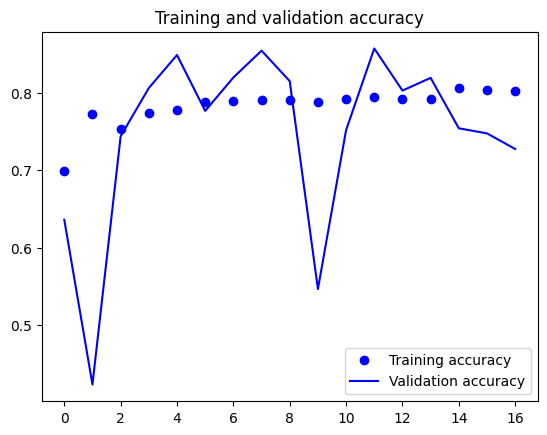

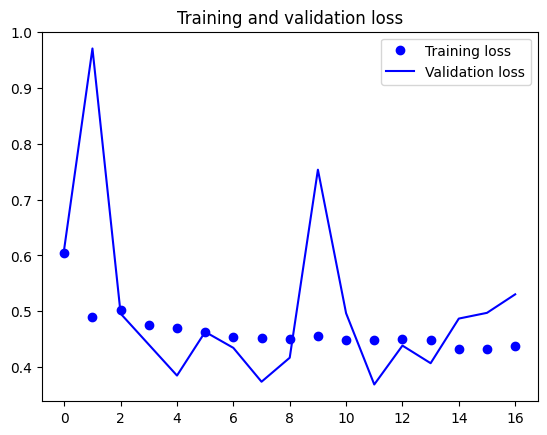

In [ ]:
run_model(model3, "Experiment3_remove_blocks_feature_extraction")

67/67 [==============================] - 6s 81ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.7897    0.7284    0.7578       696
           1     0.8732    0.9061    0.8893      1437

    accuracy                         0.8481      2133
   macro avg     0.8315    0.8173    0.8236      2133
weighted avg     0.8460    0.8481    0.8464      2133



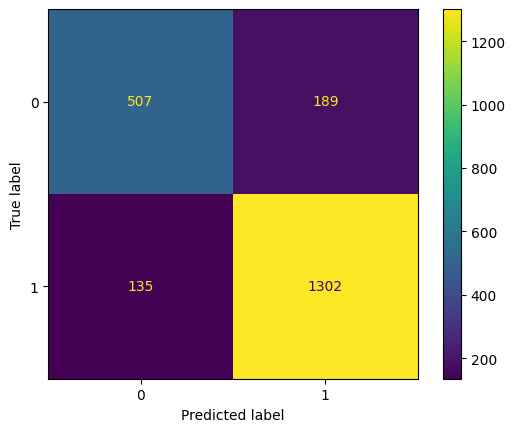

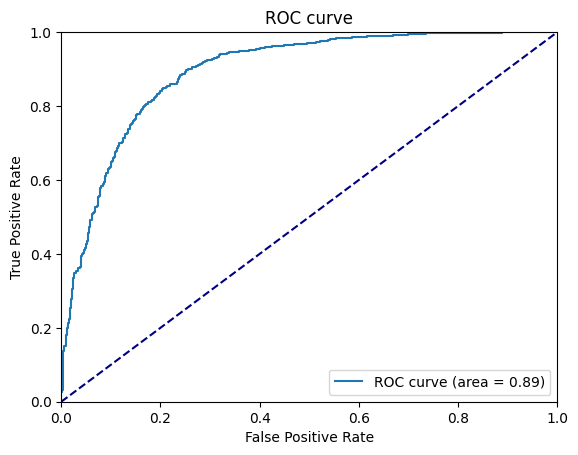

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment3_remove_blocks_feature_extraction.h5'))

#### Experiment 4: one dense layer with 512 neurons
Try to make a more complex networks increasing the neurons of a single Dense layer. We use RMSprop that in this case give us a smoother learning curve.

In [61]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = keras.applications.xception.preprocess_input(inputs)
x = base(x)
x = layers.GlobalAveragePooling2D() (x)
x = layers.Dense(512)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model4 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model4, optimizer='rmsprop', learning_rate=5e-5)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_8 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_8 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 base (Functional)           (None, 7, 7, 1024)        14805848  
                                                                 
 global_average_pooling2d_5  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                           

Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: 0.8454 - accuracy: 0.6007
Epoch 1: val_loss improved from inf to 0.56307, saving model to /content/models/Experiment4_remove_blocks_feature_extraction.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 37s 167ms/step - loss: 0.8454 - accuracy: 0.6007 - val_loss: 0.5631 - val_accuracy: 0.7092
Epoch 2/50
200/200 [==============================] - ETA: 0s - loss: 0.7126 - accuracy: 0.6614
Epoch 2: val_loss did not improve from 0.56307
200/200 [==============================] - 32s 161ms/step - loss: 0.7126 - accuracy: 0.6614 - val_loss: 0.5687 - val_accuracy: 0.7514
Epoch 3/50
200/200 [==============================] - ETA: 0s - loss: 0.6821 - accuracy: 0.6889
Epoch 3: val_loss improved from 0.56307 to 0.43076, saving model to /content/models/Experiment4_remove_blocks_feature_extraction.h5
200/200 [==============================] - 32s 160ms/step - loss: 0.6821 - accuracy: 0.6889 - val_loss: 0.4308 - val_accuracy: 0.8147
Epoch 4/50
200/200 [==============================] - ETA: 0s - loss: 0.6499 - accuracy: 0.7053
Epoch 4: val_loss did not improve from 0.43076
200/200 [==============================] - 34s 171ms/step - loss: 0.6499 - accuracy:

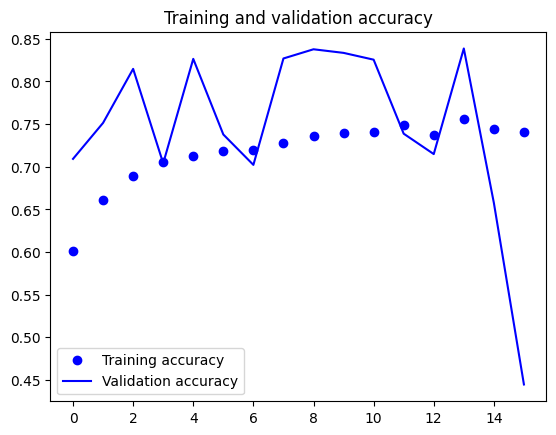

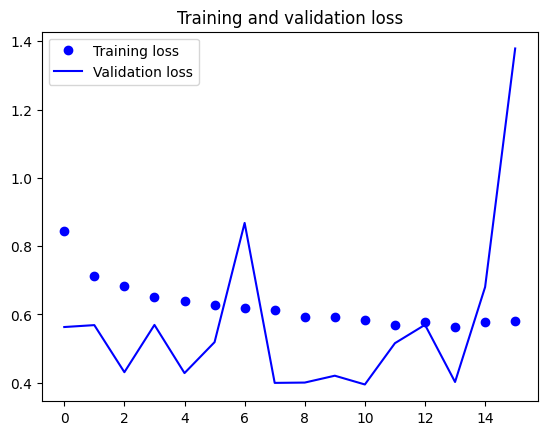

In [62]:
run_model(model4, "Experiment4_remove_blocks_feature_extraction", epochs=50)

67/67 [==============================] - 8s 118ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.7183    0.7328    0.7255       696
           1     0.8693    0.8608    0.8650      1437

    accuracy                         0.8190      2133
   macro avg     0.7938    0.7968    0.7952      2133
weighted avg     0.8200    0.8190    0.8195      2133



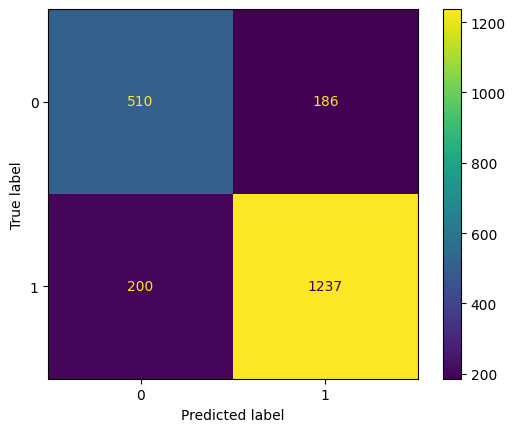

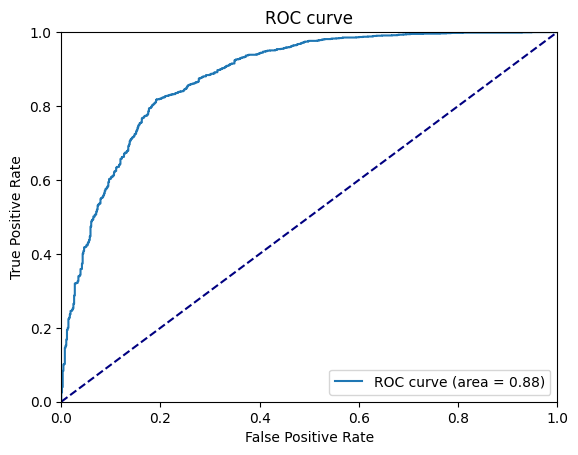

In [63]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment4_remove_blocks_feature_extraction.h5'))

#### Experiment 5: two dense layers of 512 neurons
Try to make a more complex networks with two fully-connected dense layer of 512 neurons. We use RMSprop that in this case give us a smoother learning curve.

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = keras.applications.resnet_v2.preprocess_input(inputs)
x = base(x)
x = layers.GlobalAveragePooling2D() (x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model5 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model5, optimizer='rmsprop')

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_11 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 tf.math.subtract_11 (TFOpL  (None, 224, 224, 3)       0         
 ambda)                                                          
                                                                 
 base (Functional)           (None, 14, 14, 1024)      8573440   
                                                                 
 global_average_pooling2d_6  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                           

Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: 0.6473 - accuracy: 0.6467
Epoch 1: val_loss improved from inf to 0.56564, saving model to /content/models/Experiment5_remove_blocks_feature_extraction.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 26s 115ms/step - loss: 0.6473 - accuracy: 0.6467 - val_loss: 0.5656 - val_accuracy: 0.6754
Epoch 2/50
200/200 [==============================] - ETA: 0s - loss: 0.5563 - accuracy: 0.7167
Epoch 2: val_loss improved from 0.56564 to 0.47368, saving model to /content/models/Experiment5_remove_blocks_feature_extraction.h5
200/200 [==============================] - 23s 112ms/step - loss: 0.5563 - accuracy: 0.7167 - val_loss: 0.4737 - val_accuracy: 0.8096
Epoch 3/50
200/200 [==============================] - ETA: 0s - loss: 0.5239 - accuracy: 0.7403
Epoch 3: val_loss improved from 0.47368 to 0.44343, saving model to /content/models/Experiment5_remove_blocks_feature_extraction.h5
200/200 [==============================] - 23s 112ms/step - loss: 0.5239 - accuracy: 0.7403 - val_loss: 0.4434 - val_accuracy: 0.8204
Epoch 4/50
200/200 [==============================] - ETA: 0s - loss: 0.5082 - accuracy: 0.7561
Epoch 4: val_loss did not improve from 0.44343

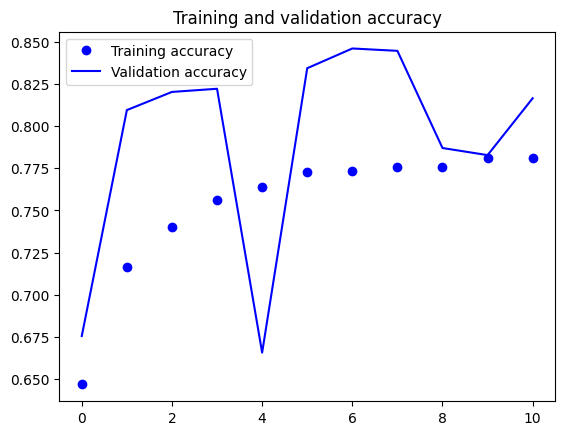

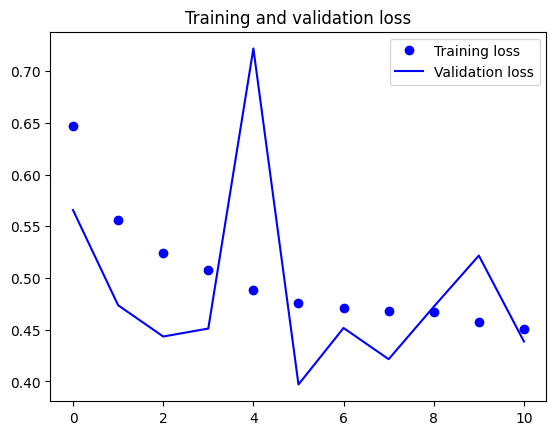

In [ ]:
run_model(model5, "Experiment5_remove_blocks_feature_extraction", epochs=50)

67/67 [==============================] - 7s 84ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.8852    0.5761    0.6980       696
           1     0.8244    0.9638    0.8887      1437

    accuracy                         0.8373      2133
   macro avg     0.8548    0.7700    0.7933      2133
weighted avg     0.8442    0.8373    0.8265      2133



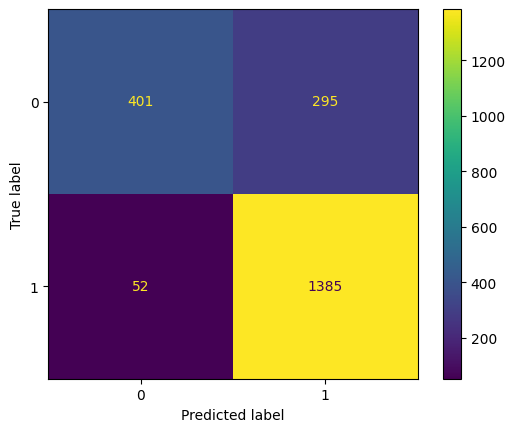

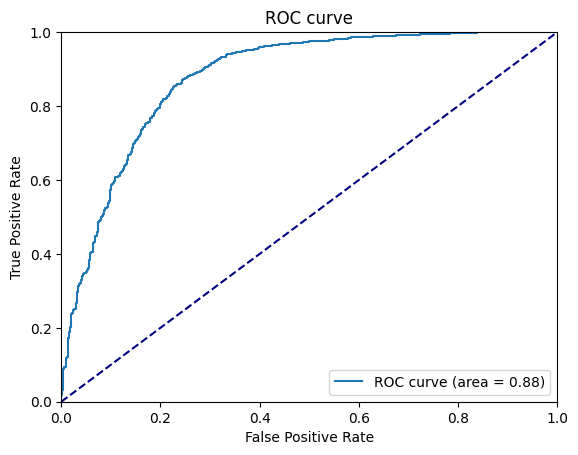

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment5_remove_blocks_feature_extraction.h5'))

### Fine tuning
Now we can fine tune the best models of the previous experiments, unfreezing some of the last layers of the base network.

#### Unfreeze some layers
Firstly, we try to unfreeze just some of the last layers of the fourth block.

##### Experiment 1: one dense layer with 256 neurons and dropout

In [ ]:
model1 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment2_remove_blocks_feature_extraction.h5')

set_trainable = False
# set trainable from "conv4_block6_1_conv"
for layer in model1.get_layer('base').layers:
    if layer.name == 'conv4_block6_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
model1.summary()

In [ ]:
compile_model(model1, learning_rate=1e-5)

In [ ]:
run_model(model1, 'Experiment1_remove_blocks_fine_tuning', epochs=30)

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment1_remove_blocks_fine_tuning.h5'))

##### Experiment 2: one dense layer with 512 neurons

In [ ]:
model2 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment4_remove_blocks_feature_extraction.h5')
set_trainable = False
# set trainable from "conv4_block6_1_conv"
for layer in model2.get_layer('base').layers:
    if layer.name == 'conv4_block6_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
model1.summary()

In [ ]:
compile_model(model2, optimizer='rmsprop', learning_rate=1e-5)

In [ ]:
run_model(model2, 'Experiment2_remove_blocks_fine_tuning', epochs=30)

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment2_remove_blocks_fine_tuning.h5'))

#### Unfreeze all the 4-th block
We try to unfreeze more layers, more precisely all the fourth block (that is the last block of our base network).

##### Experiment 3: one dense layer with 256 neurons and dropout

In [ ]:
model3 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment2_remove_blocks_feature_extraction.h5')

set_trainable = False
# set trainable all conv4 section
for layer in model3.get_layer('base').layers:
    if layer.name == 'conv4_block1_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
compile_model(model3, learning_rate=1e-5)

In [ ]:
run_model(model3, 'Experiment3_remove_blocks_fine_tuning', epochs=30)

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment3_remove_blocks_fine_tuning.h5'))

##### Experiment 4: one dense layer with 512 neurons

In [ ]:
model4 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment4_remove_blocks_feature_extraction.h5')
set_trainable = False
for layer in model4.get_layer('base').layers:
    if layer.name == 'conv4_block1_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
compile_model(model4, optimizer='rmsprop', learning_rate=1e-5)

In [ ]:
run_model(model4, 'Experiment4_remove_blocks_fine_tuning', epochs=30)

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment4_remove_blocks_fine_tuning.h5'))

##### Experiment 5: two dense layers of 512 neurons

In [ ]:
model5 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment5_remove_blocks_feature_extraction.h5')
set_trainable = False
for layer in model5.get_layer('base').layers:
    if layer.name == 'conv4_block1_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
compile_model(model5, optimizer='rmsprop', learning_rate=1e-5)

In [ ]:
run_model(model5, 'Experiment5_remove_blocks_fine_tuning', epochs=30)

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment5_remove_blocks_fine_tuning.h5'))

#### Unfreeze also the third block
We saw an improvement of our models, so we keep to unfreeze more layers. Now we unfreeze also the third block of our base network.

##### Experiment 6: one dense layer with 256 neurons and dropout

In [ ]:
model6 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment2_remove_blocks_feature_extraction.h5')

set_trainable = False
for layer in model6.get_layer('base').layers:
    if layer.name == 'conv3_block1_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
compile_model(model6, learning_rate=1e-5)

In [ ]:
run_model(model6, 'Experiment6_remove_blocks_fine_tuning', epochs=30)

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment6_remove_blocks_fine_tuning.h5'))

##### Experiment 7: one dense layer with 512 neurons

In [64]:
model7 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment4_remove_blocks_feature_extraction.h5')

set_trainable = False
for layer in model7.get_layer('base').layers:
    if layer.name == 'conv3_block1_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
compile_model(model7, optimizer='rmsprop', learning_rate=1e-5)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_8 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_8 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 base (Functional)           (None, 7, 7, 1024)        14805848  
                                                                 
 global_average_pooling2d_5  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                           

Epoch 1/30
200/200 [==============================] - ETA: 0s - loss: 0.4480 - accuracy: 0.7932
Epoch 1: val_loss improved from inf to 0.46395, saving model to /content/models/Experiment7_remove_blocks_fine_tuning.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 35s 165ms/step - loss: 0.4480 - accuracy: 0.7932 - val_loss: 0.4639 - val_accuracy: 0.7688
Epoch 2/30
200/200 [==============================] - ETA: 0s - loss: 0.4448 - accuracy: 0.7933
Epoch 2: val_loss improved from 0.46395 to 0.45781, saving model to /content/models/Experiment7_remove_blocks_fine_tuning.h5
200/200 [==============================] - 33s 162ms/step - loss: 0.4448 - accuracy: 0.7933 - val_loss: 0.4578 - val_accuracy: 0.7749
Epoch 3/30
200/200 [==============================] - ETA: 0s - loss: 0.4449 - accuracy: 0.7864
Epoch 3: val_loss improved from 0.45781 to 0.38446, saving model to /content/models/Experiment7_remove_blocks_fine_tuning.h5
200/200 [==============================] - 32s 160ms/step - loss: 0.4449 - accuracy: 0.7864 - val_loss: 0.3845 - val_accuracy: 0.8354
Epoch 4/30
200/200 [==============================] - ETA: 0s - loss: 0.4414 - accuracy: 0.7914
Epoch 4: val_loss did not improve from 0.38446
200/200 [====

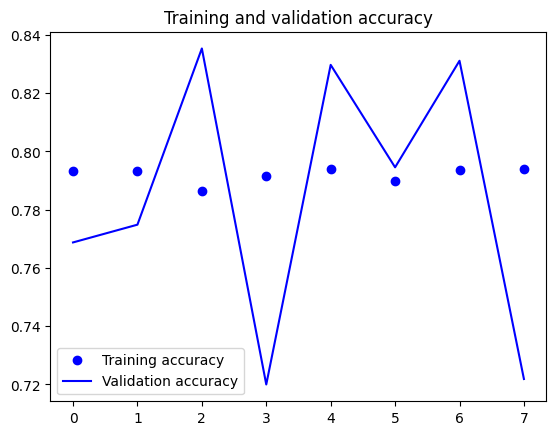

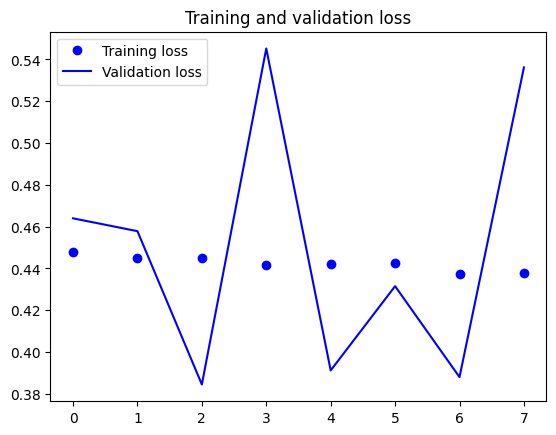

In [65]:
run_model(model7, 'Experiment7_remove_blocks_fine_tuning', epochs=30)

67/67 [==============================] - 8s 116ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.7489    0.7155    0.7318       696
           1     0.8651    0.8838    0.8744      1437

    accuracy                         0.8289      2133
   macro avg     0.8070    0.7997    0.8031      2133
weighted avg     0.8272    0.8289    0.8278      2133



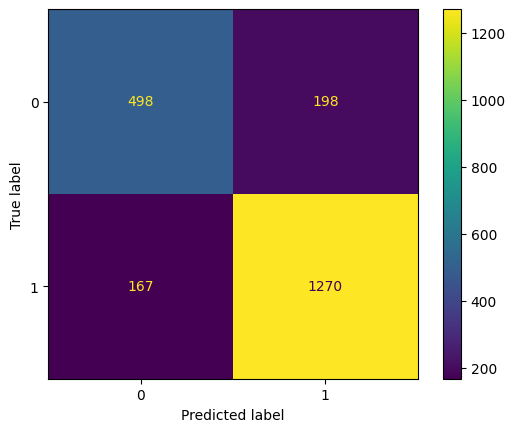

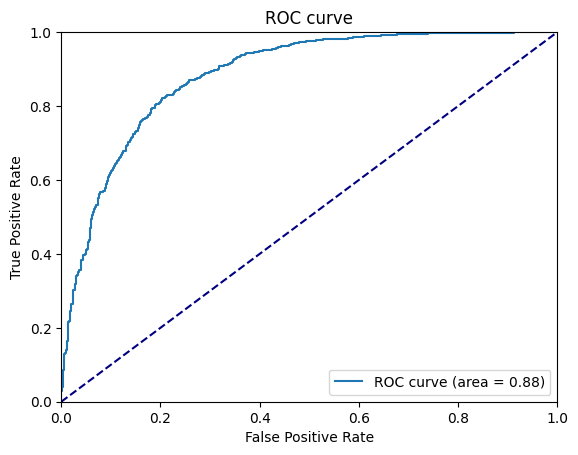

In [66]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment7_remove_blocks_fine_tuning.h5'))

#### Unfreeze also the second block
We try to unfreeze also the entire second block

##### Experiment 8: one dense layer with 256 neurons and dropout

In [67]:
model8 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment2_remove_blocks_feature_extraction.h5')

set_trainable = False
for layer in model8.get_layer('base').layers:
    if layer.name == 'conv2_block1_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
compile_model(model8, learning_rate=1e-5)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_6 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_6 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 base (Functional)           (None, 7, 7, 1024)        14805848  
                                                                 
 global_average_pooling2d_3  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                           

Epoch 1/30
200/200 [==============================] - ETA: 0s - loss: 0.4856 - accuracy: 0.7713
Epoch 1: val_loss improved from inf to 0.43876, saving model to /content/models/Experiment8_remove_blocks_fine_tuning.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 37s 166ms/step - loss: 0.4856 - accuracy: 0.7713 - val_loss: 0.4388 - val_accuracy: 0.7871
Epoch 2/30
200/200 [==============================] - ETA: 0s - loss: 0.4662 - accuracy: 0.7846
Epoch 2: val_loss did not improve from 0.43876
200/200 [==============================] - 32s 159ms/step - loss: 0.4662 - accuracy: 0.7846 - val_loss: 0.4419 - val_accuracy: 0.7842
Epoch 3/30
200/200 [==============================] - ETA: 0s - loss: 0.4543 - accuracy: 0.7878
Epoch 3: val_loss improved from 0.43876 to 0.41360, saving model to /content/models/Experiment8_remove_blocks_fine_tuning.h5
200/200 [==============================] - 32s 160ms/step - loss: 0.4543 - accuracy: 0.7878 - val_loss: 0.4136 - val_accuracy: 0.8030
Epoch 4/30
200/200 [==============================] - ETA: 0s - loss: 0.4433 - accuracy: 0.7916
Epoch 4: val_loss did not improve from 0.41360
200/200 [==============================] - 34s 171ms/step - loss: 0.4433 - accuracy: 0.7916

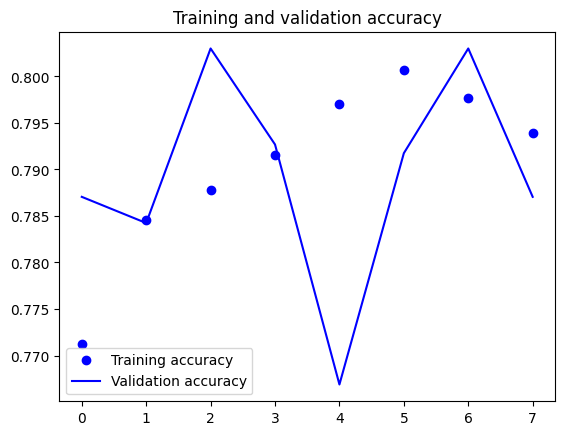

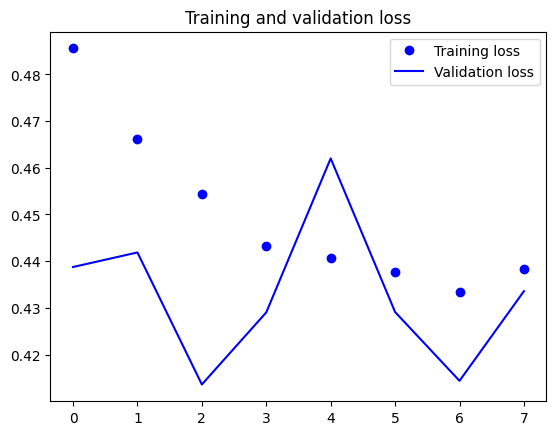

In [68]:
run_model(model8, 'Experiment8_remove_blocks_fine_tuning', epochs=30)

67/67 [==============================] - 8s 118ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.6581    0.8103    0.7263       696
           1     0.8966    0.7961    0.8433      1437

    accuracy                         0.8008      2133
   macro avg     0.7773    0.8032    0.7848      2133
weighted avg     0.8187    0.8008    0.8052      2133



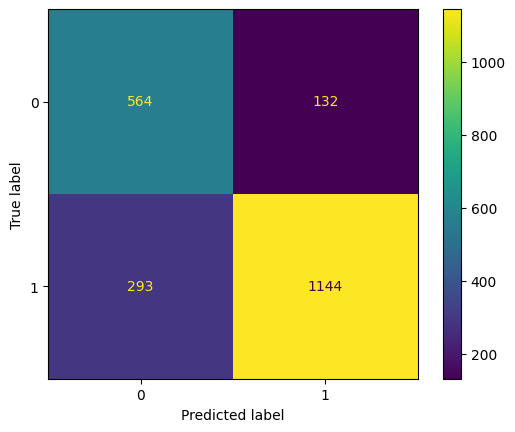

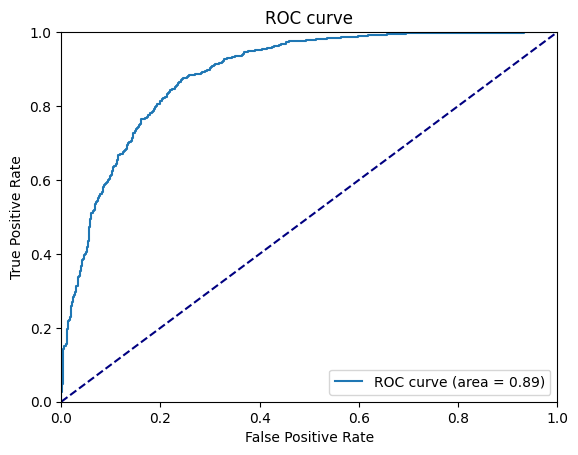

In [69]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment8_remove_blocks_fine_tuning.h5'))

##### Experiment 9: one dense layer with 512 neurons

In [70]:
model9 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment4_remove_blocks_feature_extraction.h5')

set_trainable = False
for layer in model9.get_layer('base').layers:
    if layer.name == 'conv2_block1_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
compile_model(model9, learning_rate=1e-5)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_8 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_8 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 base (Functional)           (None, 7, 7, 1024)        14805848  
                                                                 
 global_average_pooling2d_5  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                           

Epoch 1/30
200/200 [==============================] - ETA: 0s - loss: 0.4414 - accuracy: 0.7911
Epoch 1: val_loss improved from inf to 0.43049, saving model to /content/models/Experiment9_remove_blocks_fine_tuning.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 38s 175ms/step - loss: 0.4414 - accuracy: 0.7911 - val_loss: 0.4305 - val_accuracy: 0.7969
Epoch 2/30
200/200 [==============================] - ETA: 0s - loss: 0.4461 - accuracy: 0.7922
Epoch 2: val_loss did not improve from 0.43049
200/200 [==============================] - 32s 160ms/step - loss: 0.4461 - accuracy: 0.7922 - val_loss: 0.5041 - val_accuracy: 0.7397
Epoch 3/30
200/200 [==============================] - ETA: 0s - loss: 0.4500 - accuracy: 0.7874
Epoch 3: val_loss did not improve from 0.43049
200/200 [==============================] - 34s 170ms/step - loss: 0.4500 - accuracy: 0.7874 - val_loss: 0.5071 - val_accuracy: 0.7373
Epoch 4/30
200/200 [==============================] - ETA: 0s - loss: 0.4401 - accuracy: 0.7941
Epoch 4: val_loss did not improve from 0.43049
200/200 [==============================] - 34s 171ms/step - loss: 0.4401 - accuracy: 0.7941 - val_loss: 0.4901 - val_accuracy: 0.7491
Epoch 5/30
200/200 [===============

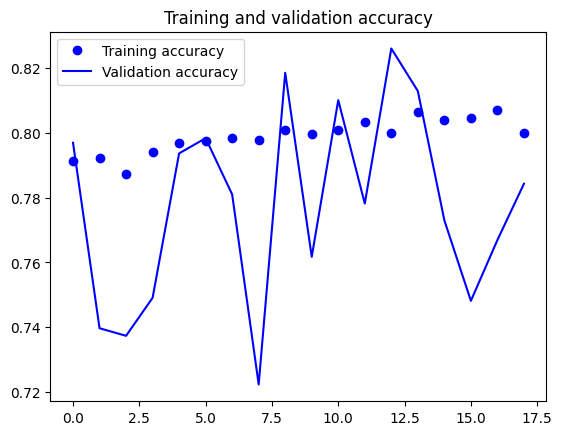

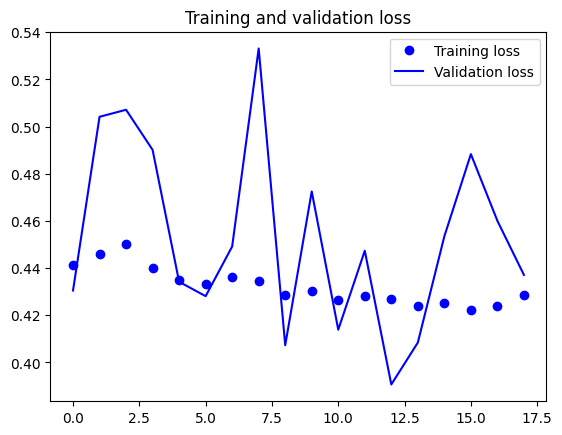

In [71]:
run_model(model9, 'Experiment9_remove_blocks_fine_tuning', epochs=30)

67/67 [==============================] - 9s 118ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.7057    0.7716    0.7371       696
           1     0.8841    0.8441    0.8637      1437

    accuracy                         0.8204      2133
   macro avg     0.7949    0.8078    0.8004      2133
weighted avg     0.8259    0.8204    0.8224      2133



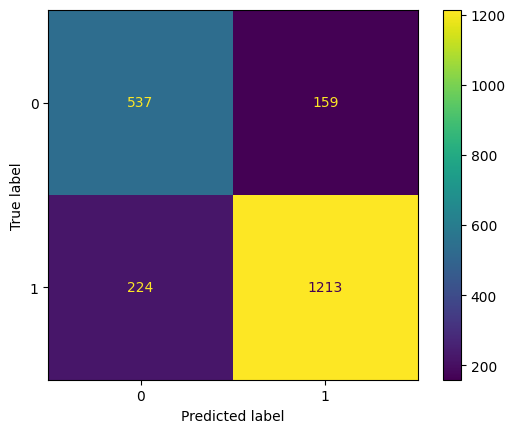

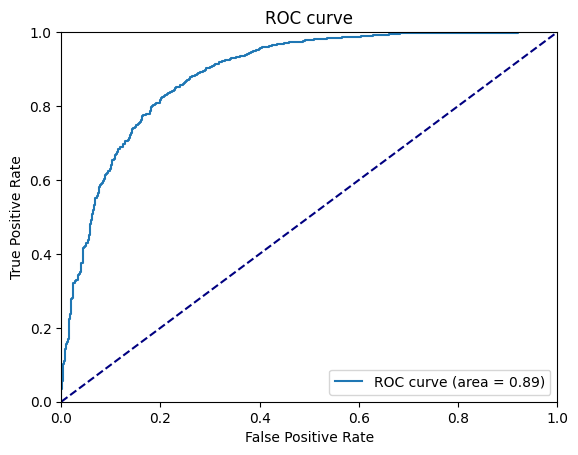

In [72]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment9_remove_blocks_fine_tuning.h5'))

#### Unfreeze all the base network
Let's try to unfreeze all the layers of the base network

##### Experiment 10: one dense layer with 256 neurons and dropout

In [73]:
model10 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment2_remove_blocks_feature_extraction.h5')
model10.trainable = True
compile_model(model10, learning_rate=1e-5)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_6 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_6 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 base (Functional)           (None, 7, 7, 1024)        14805848  
                                                                 
 global_average_pooling2d_3  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                           

Epoch 1/30
200/200 [==============================] - ETA: 0s - loss: 0.4995 - accuracy: 0.7802
Epoch 1: val_loss improved from inf to 0.50525, saving model to /content/models/Experiment10_remove_blocks_fine_tuning.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 127s 503ms/step - loss: 0.4995 - accuracy: 0.7802 - val_loss: 0.5053 - val_accuracy: 0.8035
Epoch 2/30
200/200 [==============================] - ETA: 0s - loss: 0.3396 - accuracy: 0.8535
Epoch 2: val_loss improved from 0.50525 to 0.29115, saving model to /content/models/Experiment10_remove_blocks_fine_tuning.h5
200/200 [==============================] - 96s 477ms/step - loss: 0.3396 - accuracy: 0.8535 - val_loss: 0.2912 - val_accuracy: 0.8766
Epoch 3/30
200/200 [==============================] - ETA: 0s - loss: 0.2659 - accuracy: 0.8890
Epoch 3: val_loss improved from 0.29115 to 0.24638, saving model to /content/models/Experiment10_remove_blocks_fine_tuning.h5
200/200 [==============================] - 98s 488ms/step - loss: 0.2659 - accuracy: 0.8890 - val_loss: 0.2464 - val_accuracy: 0.8996
Epoch 4/30
200/200 [==============================] - ETA: 0s - loss: 0.1963 - accuracy: 0.9242
Epoch 4: val_loss did not improve from 0.24638
200/200 [=

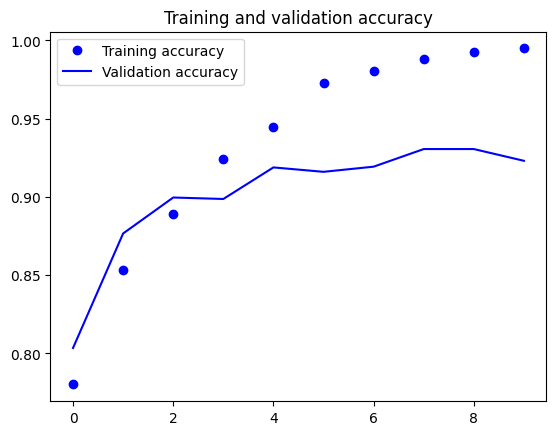

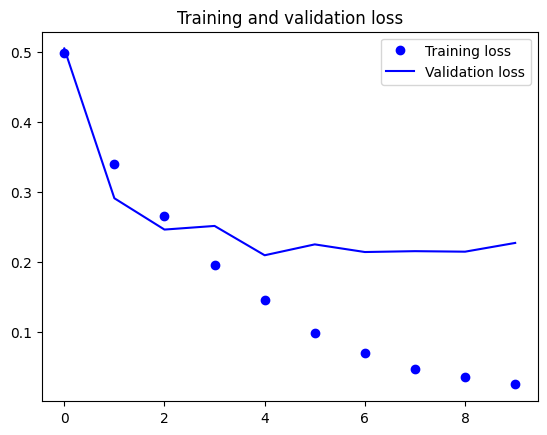

In [74]:
run_model(model10, 'Experiment10_remove_blocks_fine_tuning', epochs=30)

67/67 [==============================] - 8s 118ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.8438    0.8922    0.8673       696
           1     0.9463    0.9200    0.9330      1437

    accuracy                         0.9109      2133
   macro avg     0.8950    0.9061    0.9001      2133
weighted avg     0.9128    0.9109    0.9115      2133



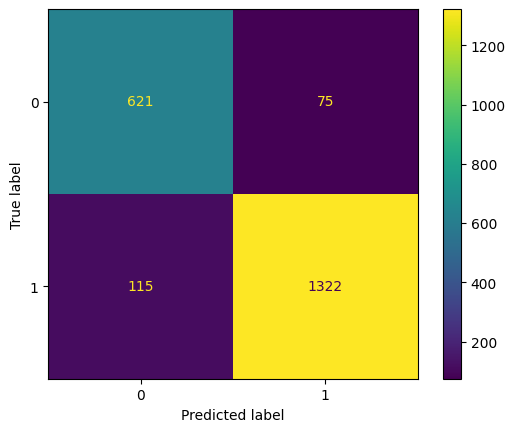

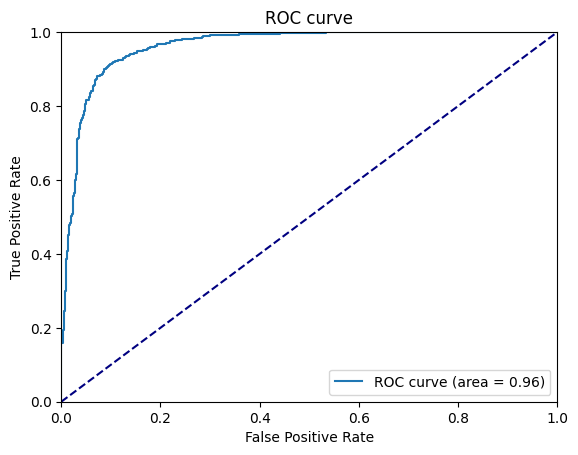

In [75]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment10_remove_blocks_fine_tuning.h5'))

##### Experiment 11: one dense layer with 512 neurons

In [77]:
model11 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment4_remove_blocks_feature_extraction.h5')
model11.trainable = True
compile_model(model11, learning_rate=1e-5)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_8 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_8 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 base (Functional)           (None, 7, 7, 1024)        14805848  
                                                                 
 global_average_pooling2d_5  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                           

Epoch 1/30
200/200 [==============================] - ETA: 0s - loss: 0.4681 - accuracy: 0.7908
Epoch 1: val_loss improved from inf to 0.64176, saving model to /content/models/Experiment11_remove_blocks_fine_tuning.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 117s 483ms/step - loss: 0.4681 - accuracy: 0.7908 - val_loss: 0.6418 - val_accuracy: 0.7735
Epoch 2/30
200/200 [==============================] - ETA: 0s - loss: 0.3216 - accuracy: 0.8601
Epoch 2: val_loss improved from 0.64176 to 0.26808, saving model to /content/models/Experiment11_remove_blocks_fine_tuning.h5
200/200 [==============================] - 96s 479ms/step - loss: 0.3216 - accuracy: 0.8601 - val_loss: 0.2681 - val_accuracy: 0.8963
Epoch 3/30
200/200 [==============================] - ETA: 0s - loss: 0.2530 - accuracy: 0.8960
Epoch 3: val_loss improved from 0.26808 to 0.24072, saving model to /content/models/Experiment11_remove_blocks_fine_tuning.h5
200/200 [==============================] - 98s 490ms/step - loss: 0.2530 - accuracy: 0.8960 - val_loss: 0.2407 - val_accuracy: 0.9034
Epoch 4/30
200/200 [==============================] - ETA: 0s - loss: 0.1813 - accuracy: 0.9320
Epoch 4: val_loss improved from 0.24072 to 0.20822, savin

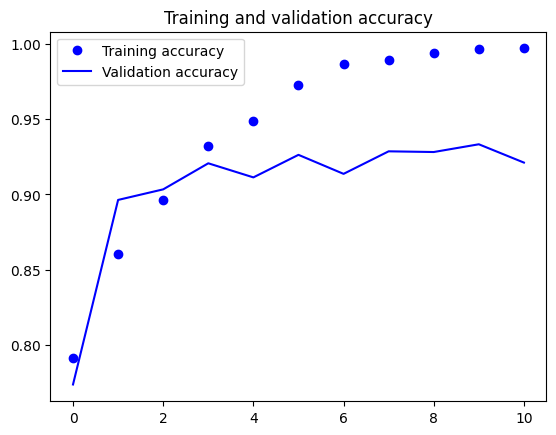

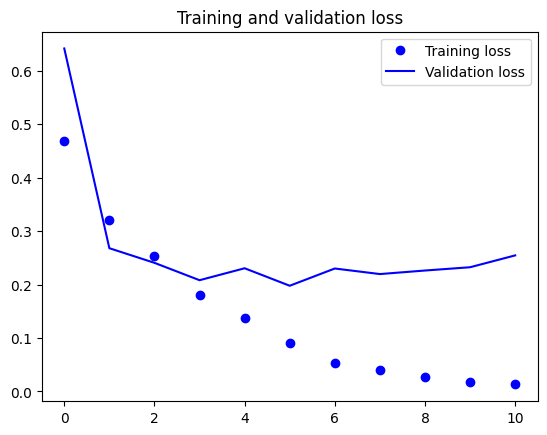

In [78]:
run_model(model11, 'Experiment11_remove_blocks_fine_tuning', epochs=30)

67/67 [==============================] - 9s 118ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.8703    0.8678    0.8691       696
           1     0.9361    0.9374    0.9367      1437

    accuracy                         0.9147      2133
   macro avg     0.9032    0.9026    0.9029      2133
weighted avg     0.9146    0.9147    0.9146      2133



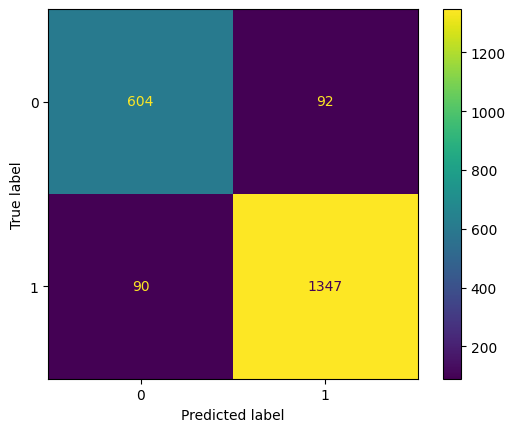

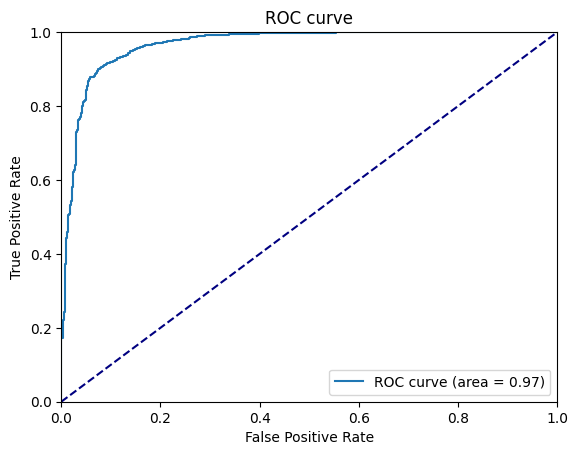

In [79]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment11_remove_blocks_fine_tuning.h5'))

# CLAHE
We will try now to use the dataset in which the images are preprocesses with CLAHE. We will test the performance with the best network previuosly found and we will compare the results. Unfortunately, no significant improvements were found.

## Load dataset from Google Drive
The dataset is stored in Google Drive in a zip file, we unzip it locally for better performance.

In [ ]:
drive.mount('/content/drive', force_remount=True)
!unzip -q "/content/drive/My Drive/SplittedDataset_CLAHE.zip" -d "/content"

## Set parameters

In [ ]:
DATASET_PATH = "/content/SplittedDataset_CLAHE"
TRAINING_PATH = DATASET_PATH + '/training_set'
TRAINING_ALL_PATH = TRAINING_PATH + '/all'
TRAINING_HEM_PATH = TRAINING_PATH + '/hem'
VALIDATION_PATH = DATASET_PATH + '/validation_set'
TEST_PATH = DATASET_PATH + '/test_set'

## Load dataset
The dataset, properly preprocessed, is now located in the local machine.

In [ ]:
set_seed()

train_dataset = load_training_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)
validation_dataset = load_validation_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)
test_dataset = load_test_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)

## Remove final block
As we did for the original dataset, here too we are going to remove the last block that deals with the high-level features of Imagenet

In [ ]:
conv_base = keras.applications.resnet.ResNet50(include_top = False, weights='imagenet', input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3))

In [ ]:
base = Model(conv_base.input, conv_base.layers[get_index_by_layer_name(conv_base, 'conv4_block6_out')].output, name='base')
base.trainable = False
base.summary()

## Feature extraction
Firstly, we try the simplest approach in which we use the pretrained network to extract feature and we use our classifier to classify the images.

### Experiment 1: one dense layer with 256 neurons and dropout
This is the first best model found in the previous section with the standard dataset.

In [ ]:
# define the classifier
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = keras.applications.resnet50.preprocess_input(inputs)
x = base(x)
x = layers.GlobalAveragePooling2D() (x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model1 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model1)

In [ ]:
run_model(model1, "Experiment1_remove_blocks_feature_extraction_CLAHE", epochs=50)

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment1_remove_blocks_feature_extraction_CLAHE.h5'))

## Fine Tuning
Now we can fine-tune the base network to adapt it to extract more useful features in our images.

### Unfreeze up to the second block included
We tried directly to unfreeze up to the second block included, just to compare with the previous results. We can easily see that unfortunately there are no significative improvements, indeed the results are less satisfactory than the same network on the original dataset.

#### Experiment 1: one dense layer with 256 neurons and dropout

In [ ]:
model1 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment1_remove_blocks_feature_extraction_CLAHE.h5')

set_trainable = False
for layer in model1.get_layer('base').layers:
    if layer.name == 'conv2_block1_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
compile_model(model1, learning_rate=1e-5)

In [ ]:
run_model(model1, "Experiment1_remove_blocks_fine_tuning_CLAHE", epochs=50)

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment1_remove_blocks_fine_tuning_CLAHE.h5'))